In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import aquarel as aq
from ineqpy.inequality import gini
import scipy.stats as st
import pyalex as alex
alex.config.email = "noah0roussel01980@gmail.com"

In [2]:
works_bjp = pl.read_csv("../data/works/works_bjp.csv")
works_bjp = works_bjp.filter(pl.col("year") != 2025)

works = pl.read_csv("../data/works/works_q1.csv")
works = works.filter(pl.col("year") != 2025)

In [3]:
year_begin = 1920
year_end = 2024
works_bjp = works_bjp.with_columns(
    age=2025 - pl.col("year")
)

bjp_cbc_per_year = (
    works_bjp
    .select(
        [pl.col("year"), pl.col("cited_by_count"), pl.col("title")]
    )
    .group_by(
        pl.col("year"),
        maintain_order=True
    )
    .agg(
        pl.col("cited_by_count").mean().name.prefix("mean_")
    )
) 

works_bjp = works_bjp.join(
    bjp_cbc_per_year,
    on="year",
    how="left"
) 

works_bjp = (
    works_bjp
    .with_columns(
        mncs = pl.col("cited_by_count") / pl.col("mean_cited_by_count")
    )
    .drop("mean_cited_by_count")
)
bjp_cols_authors = [col for col in works_bjp.columns if col.startswith("author_")]

works_bjp = works_bjp.with_columns(
    authors_count = sum(
        [pl.col(col).is_not_null().cast(pl.Int8) for col in bjp_cols_authors]
    )

)

works_bjp = works_bjp.with_columns(
    title = pl.col("title").fill_null("").str.to_lowercase(),
    abstract = pl.col("abstract").fill_null("").str.to_lowercase()
)

works_bjp = works_bjp.with_columns(
    review = (
        pl.col("title").str.contains("review") |
        pl.col("abstract").str.contains("review")
    ),
    meta_analysis = (
        pl.col("title").str.contains("meta[\u00AD-]?analysis") |
        pl.col("abstract").str.contains("meta[\u00AD-]?analysis")
    )
)

works_bjp = works_bjp.with_columns([
    pl.when(pl.col("countries_distinct_count").is_null() | pl.col("countries_distinct_count").is_nan() | (pl.col("countries_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("countries_distinct_count"))
      .alias("countries_distinct_count")
])
works_bjp = works_bjp.with_columns([
    pl.when(pl.col("institutions_distinct_count").is_null() | pl.col("institutions_distinct_count").is_nan() | (pl.col("institutions_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("institutions_distinct_count"))
      .alias("institutions_distinct_count")
])


bjp_group_references_mean = (
    works_bjp.lazy()  
    .filter(~pl.col("review") & ~pl.col("meta_analysis"))
    .group_by("referenced_works_count")
    .agg([
        pl.col("mncs").mean().alias("mncs"),
        pl.len().alias("count")
    ])
    .sort("referenced_works_count")
    .collect()  
)

works_bjp

shape: (26_115, 394)
┌─────────────┬──────┬─────────────┬────────────┬───┬───────────┬────────────┬────────┬────────────┐
│ title       ┆ year ┆ cited_by_co ┆ countries_ ┆ … ┆ mncs      ┆ authors_co ┆ review ┆ meta_analy │
│ ---         ┆ ---  ┆ unt         ┆ distinct_c ┆   ┆ ---       ┆ unt        ┆ ---    ┆ sis        │
│ str         ┆ i64  ┆ ---         ┆ ount       ┆   ┆ f64       ┆ ---        ┆ bool   ┆ ---        │
│             ┆      ┆ i64         ┆ ---        ┆   ┆           ┆ i8         ┆        ┆ bool       │
│             ┆      ┆             ┆ i64        ┆   ┆           ┆            ┆        ┆            │
╞═════════════╪══════╪═════════════╪════════════╪═══╪═══════════╪════════════╪════════╪════════════╡
│ animal      ┆ 2010 ┆ 3465        ┆ 1          ┆ … ┆ 49.882425 ┆ 5          ┆ false  ┆ false      │
│ research:   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ reporting   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ <i>…        ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ principles  ┆ 2010 ┆ 2474        ┆ 1          ┆ … ┆ 35.615907 ┆ 4          ┆ true   ┆ false      │
│ of early    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ drug disco… ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ measuring   ┆ 2004 ┆ 2200        ┆ 1          ┆ … ┆ 36.17912  ┆ 2          ┆ true   ┆ false      │
│ reactive    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ species     ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ and…        ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ guide to    ┆ 2011 ┆ 2073        ┆ 1          ┆ … ┆ 29.964208 ┆ 3          ┆ false  ┆ false      │
│ receptors   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ and         ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ channel…    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ characteriz ┆ 1990 ┆ 1876        ┆ 1          ┆ … ┆ 40.01629  ┆ 5          ┆ false  ┆ false      │
│ ation of    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ three inhi… ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ …           ┆ …    ┆ …           ┆ …          ┆ … ┆ …         ┆ …          ┆ …      ┆ …          │
│             ┆ 1986 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 0          ┆ false  ┆ false      │
│ transdermal ┆ 1994 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 2          ┆ false  ┆ false      │
│ iontophores ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ is - ro…    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ oral commun ┆ 1991 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 2          ┆ false  ┆ false      │
│ ications    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ interleukin ┆ 1989 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 2          ┆ false  ┆ false      │
│ 1 and lipop ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ olysacc…    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ effect of   ┆ 1994 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 3          ┆ false  ┆ false      │
│ 8-br-cgmp   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ on current… ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
└─────────────┴──────┴─────────────┴────────────┴───┴───────────┴────────────┴────────┴────────────┘

In [4]:
year_begin = 1920
year_end = 2024
works = works.with_columns(
    age=2025 - pl.col("year")
)

cbc_per_year = (
    works
    .select(
        [pl.col("year"), pl.col("cited_by_count"), pl.col("title")]
    )
    .group_by(
        pl.col("year"),
        maintain_order=True
    )
    .agg(
        pl.col("cited_by_count").mean().name.prefix("mean_")
    )
) 

works = works.join(
    cbc_per_year,
    on="year",
    how="left"
) 

works = (
    works
    .with_columns(
        mncs = pl.col("cited_by_count") / pl.col("mean_cited_by_count")
    )
    .drop("mean_cited_by_count")
)
cols_authors = [col for col in works.columns if col.startswith("author_")]

works = works.with_columns(
    authors_count = sum(
        [pl.col(col).is_not_null().cast(pl.Int8) for col in cols_authors]
    )

)

works = works.with_columns(
    title = pl.col("title").fill_null("").str.to_lowercase(),
    abstract = pl.col("abstract").fill_null("").str.to_lowercase()
)

works = works.with_columns(
    review = (
        pl.col("title").str.contains("review") |
        pl.col("abstract").str.contains("review")
    ),
    meta_analysis = (
        pl.col("title").str.contains("meta[\u00AD-]?analysis") |
        pl.col("abstract").str.contains("meta[\u00AD-]?analysis")
    )
)

works = works.with_columns([
    pl.when(pl.col("countries_distinct_count").is_null() | pl.col("countries_distinct_count").is_nan() | (pl.col("countries_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("countries_distinct_count"))
      .alias("countries_distinct_count")
])
works = works.with_columns([
    pl.when(pl.col("institutions_distinct_count").is_null() | pl.col("institutions_distinct_count").is_nan() | (pl.col("institutions_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("institutions_distinct_count"))
      .alias("institutions_distinct_count")
])


group_references_mean = (
    works.lazy()  
    .filter(~pl.col("review") & ~pl.col("meta_analysis"))
    .group_by("referenced_works_count")
    .agg([
        pl.col("mncs").mean().alias("mncs"),
        pl.len().alias("count")
    ])
    .sort("referenced_works_count")
    .collect()  
)

works


shape: (689_361, 1_080)
┌─────────────┬──────┬─────────────┬────────────┬───┬───────────┬────────────┬────────┬────────────┐
│ title       ┆ year ┆ cited_by_co ┆ countries_ ┆ … ┆ mncs      ┆ authors_co ┆ review ┆ meta_analy │
│ ---         ┆ ---  ┆ unt         ┆ distinct_c ┆   ┆ ---       ┆ unt        ┆ ---    ┆ sis        │
│ str         ┆ i64  ┆ ---         ┆ ount       ┆   ┆ f64       ┆ ---        ┆ bool   ┆ ---        │
│             ┆      ┆ i64         ┆ ---        ┆   ┆           ┆ i8         ┆        ┆ bool       │
│             ┆      ┆             ┆ i64        ┆   ┆           ┆            ┆        ┆            │
╞═════════════╪══════╪═════════════╪════════════╪═══╪═══════════╪════════════╪════════╪════════════╡
│ ros stress  ┆ 2004 ┆ 1881        ┆ 1          ┆ … ┆ 35.103559 ┆ 3          ┆ false  ┆ false      │
│ in cancer   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ cells and…  ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ aminoglycos ┆ 2010 ┆ 1294        ┆ 1          ┆ … ┆ 24.857588 ┆ 2          ┆ false  ┆ false      │
│ ide         ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ modifying   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ enzym…      ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ overcoming  ┆ 2015 ┆ 898         ┆ 2          ┆ … ┆ 23.127161 ┆ 6          ┆ false  ┆ false      │
│ the         ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ blood–brain ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ tum…        ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ targeting   ┆ 2008 ┆ 786         ┆ 1          ┆ … ┆ 14.902469 ┆ 4          ┆ false  ┆ false      │
│ the pi3k/ak ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ t/mtor pa…  ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ if not      ┆ 2001 ┆ 722         ┆ 1          ┆ … ┆ 12.263251 ┆ 3          ┆ false  ┆ false      │
│ apoptosis,  ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ then what?  ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ t…          ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ …           ┆ …    ┆ …           ┆ …          ┆ … ┆ …         ┆ …          ┆ …      ┆ …          │
│ contributor ┆ 1992 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 0          ┆ false  ┆ false      │
│ s           ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ copyright   ┆ 1992 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 0          ┆ false  ┆ false      │
│ preface     ┆ 1992 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 1          ┆ false  ┆ false      │
│ dendritic   ┆ 1991 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 1          ┆ false  ┆ false      │
│ cells in    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ the         ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ inducti…    ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ protein con ┆ 1991 ┆ 0           ┆ 1          ┆ … ┆ 0.0       ┆ 6          ┆ false  ┆ false      │
│ formation   ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
│ affects t…  ┆      ┆             ┆            ┆   ┆           ┆            ┆        ┆            │
└─────────────┴──────┴─────────────┴────────────┴───┴───────────┴────────────┴────────┴────────────┘

In [5]:
countries_col = [f"country_{i}" for i in range(1, 193)]

countries= (
    works
    .select(["year", "cited_by_count", "mncs", *countries_col])  
    .sort("year")
    .with_row_index("index_work")
    .unpivot(
        on=countries_col,
        index=["year", "index_work", "cited_by_count", "mncs"],
        variable_name="country_pos",
        value_name="country_name"
    )
    .filter(pl.col("country_name").is_not_null())
    .with_columns(count=pl.lit(1, dtype=pl.Int8))  
)

countries

shape: (3_134_800, 7)
┌──────┬────────────┬────────────────┬──────────┬─────────────┬──────────────┬───────┐
│ year ┆ index_work ┆ cited_by_count ┆ mncs     ┆ country_pos ┆ country_name ┆ count │
│ ---  ┆ ---        ┆ ---            ┆ ---      ┆ ---         ┆ ---          ┆ ---   │
│ i64  ┆ u32        ┆ i64            ┆ f64      ┆ str         ┆ str          ┆ i8    │
╞══════╪════════════╪════════════════╪══════════╪═════════════╪══════════════╪═══════╡
│ 1948 ┆ 4737       ┆ 9              ┆ 0.803571 ┆ country_1   ┆ AT           ┆ 1     │
│ 1948 ┆ 4740       ┆ 1              ┆ 0.089286 ┆ country_1   ┆ CH           ┆ 1     │
│ 1955 ┆ 6245       ┆ 30             ┆ 1.534133 ┆ country_1   ┆ DE           ┆ 1     │
│ 1958 ┆ 6927       ┆ 373            ┆ 12.49231 ┆ country_1   ┆ US           ┆ 1     │
│ 1958 ┆ 6928       ┆ 177            ┆ 5.927986 ┆ country_1   ┆ US           ┆ 1     │
│ …    ┆ …          ┆ …              ┆ …        ┆ …           ┆ …            ┆ …     │
│ 2017 ┆ 506649     ┆ 18             ┆ 0.449923 ┆ country_190 ┆ GB           ┆ 1     │
│ 2015 ┆ 466011     ┆ 0              ┆ 0.0      ┆ country_191 ┆ BE           ┆ 1     │
│ 2017 ┆ 506649     ┆ 18             ┆ 0.449923 ┆ country_191 ┆ CA           ┆ 1     │
│ 2015 ┆ 466011     ┆ 0              ┆ 0.0      ┆ country_192 ┆ CA           ┆ 1     │
│ 2017 ┆ 506649     ┆ 18             ┆ 0.449923 ┆ country_192 ┆ GB           ┆ 1     │
└──────┴────────────┴────────────────┴──────────┴─────────────┴──────────────┴───────┘

In [6]:
countries_col = [f"country_{i}" for i in range(1, 121)]

countries_bjp= (
    works_bjp
    .select(["year", "cited_by_count", "mncs", *countries_col])  
    .sort("year")
    .with_row_index("index_work")
    .unpivot(
        on=countries_col,
        index=["year", "index_work", "cited_by_count", "mncs"],
        variable_name="country_pos",
        value_name="country_name"
    )
    .filter(pl.col("country_name").is_not_null())
    .with_columns(count=pl.lit(1, dtype=pl.Int8))  
)

countries_bjp

shape: (110_927, 7)
┌──────┬────────────┬────────────────┬───────────┬─────────────┬──────────────┬───────┐
│ year ┆ index_work ┆ cited_by_count ┆ mncs      ┆ country_pos ┆ country_name ┆ count │
│ ---  ┆ ---        ┆ ---            ┆ ---       ┆ ---         ┆ ---          ┆ ---   │
│ i64  ┆ u32        ┆ i64            ┆ f64       ┆ str         ┆ str          ┆ i8    │
╞══════╪════════════╪════════════════╪═══════════╪═════════════╪══════════════╪═══════╡
│ 1968 ┆ 3          ┆ 1402           ┆ 22.574862 ┆ country_1   ┆ US           ┆ 1     │
│ 1968 ┆ 5          ┆ 276            ┆ 4.444124  ┆ country_1   ┆ SE           ┆ 1     │
│ 1968 ┆ 6          ┆ 134            ┆ 2.157654  ┆ country_1   ┆ CH           ┆ 1     │
│ 1968 ┆ 7          ┆ 131            ┆ 2.109349  ┆ country_1   ┆ AU           ┆ 1     │
│ 1968 ┆ 8          ┆ 130            ┆ 2.093247  ┆ country_1   ┆ GB           ┆ 1     │
│ …    ┆ …          ┆ …              ┆ …         ┆ …           ┆ …            ┆ …     │
│ 2022 ┆ 25441      ┆ 0              ┆ 0.0       ┆ country_117 ┆ JP           ┆ 1     │
│ 2022 ┆ 25454      ┆ 0              ┆ 0.0       ┆ country_117 ┆ JP           ┆ 1     │
│ 2022 ┆ 25427      ┆ 0              ┆ 0.0       ┆ country_118 ┆ NO           ┆ 1     │
│ 2022 ┆ 25427      ┆ 0              ┆ 0.0       ┆ country_119 ┆ NL           ┆ 1     │
│ 2022 ┆ 25427      ┆ 0              ┆ 0.0       ┆ country_120 ┆ NL           ┆ 1     │
└──────┴────────────┴────────────────┴───────────┴─────────────┴──────────────┴───────┘

In [7]:
group_countriesyears = (
    countries
    .drop("country_pos")
    .group_by(["country_name", "year"], maintain_order=True).sum()
    .sort("year")
)

group_countriesyears_bjp = (
    countries_bjp
    .drop("country_pos")
    .group_by(["country_name", "year"], maintain_order=True).sum()
    .sort("year")
)

cols_to_stats = [
    "cited_by_count",
    "age",
    "count",
    "mncs"
]

agg_exprs = []

for col in cols_to_stats:
    agg_exprs.append(pl.mean(col).alias(f"{col}_mean"))
    agg_exprs.append(pl.median(col).alias(f"{col}_median"))
    agg_exprs.append(pl.col(col).quantile(0.025).alias(f"{col}_p2_5"))
    agg_exprs.append(pl.col(col).quantile(0.975).alias(f"{col}_p97_5"))

In [8]:
group_countries = (
    countries
    .with_columns(
        age=pl.lit(2025)-pl.col("year")
    )
    .drop(["country_pos", "year"])
    .group_by(
        by="country_name",
        maintain_order=True
    )
    .agg(
        count=pl.col("count").sum(),
         *agg_exprs
         )
    .sort("count", descending=True)
    .rename({"by":"country_name"})
)

group_countries_bjp = (
    countries_bjp
    .with_columns(
        age=pl.lit(2025)-pl.col("year")
    )
    .drop(["country_pos", "year"])
    .group_by(
        by="country_name",
        maintain_order=True
    )
    .agg(count=pl.col("count").sum(),
         *agg_exprs
         )  
    .sort("count", descending=True)
    .rename({"by":"country_name"})
)

group_countries = group_countries.sort("count", descending=True)
group_countires_bjp = group_countries_bjp.sort("count", descending=True)

print(group_countries_bjp)

shape: (119, 18)
┌────────────┬────────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬───────┐
│ country_na ┆ cited_by_c ┆ cited_by_c ┆ cited_by_ ┆ … ┆ mncs_medi ┆ mncs_p2_5 ┆ mncs_p97_ ┆ count │
│ me         ┆ ount_mean  ┆ ount_media ┆ count_p2_ ┆   ┆ an        ┆ ---       ┆ 5         ┆ ---   │
│ ---        ┆ ---        ┆ n          ┆ 5         ┆   ┆ ---       ┆ f64       ┆ ---       ┆ i64   │
│ str        ┆ f64        ┆ ---        ┆ ---       ┆   ┆ f64       ┆           ┆ f64       ┆       │
│            ┆            ┆ f64        ┆ f64       ┆   ┆           ┆           ┆           ┆       │
╞════════════╪════════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════╡
│ GB         ┆ 67.067028  ┆ 34.0       ┆ 1.0       ┆ … ┆ 0.744918  ┆ 0.024194  ┆ 9.088005  ┆ 20872 │
│ US         ┆ 60.210328  ┆ 36.0       ┆ 0.0       ┆ … ┆ 0.794727  ┆ 0.0       ┆ 6.475215  ┆ 15918 │
│ JP         ┆ 39.885128  ┆ 27.0       ┆ 3.0       ┆ … ┆ 0.581921  ┆ 0.070

In [9]:

cols_to_stats = [
    "cited_by_count",
    "mncs",
    "countries_distinct_count"
]

agg_exprs = []
for col in cols_to_stats:
    agg_exprs.append(pl.mean(col).alias(f"{col}_mean"))
    agg_exprs.append(pl.median(col).alias(f"{col}_median"))
    agg_exprs.append(pl.col(col).quantile(0.025).alias(f"{col}_p2_5"))
    agg_exprs.append(pl.col(col).quantile(0.975).alias(f"{col}_p97_5"))


group_Ncountries = (
    works
    .group_by("countries_distinct_count")
    .agg(*agg_exprs)
    .sort("countries_distinct_count")
)

group_Ncountries_bjp = (
    works_bjp
    .group_by("countries_distinct_count")
    .agg(*agg_exprs)
    .sort("countries_distinct_count")
)

group_Ncountries = group_Ncountries.sort("countries_distinct_count", descending=False)
group_Ncountires_bjp = group_Ncountries_bjp.sort("countries_distinct_count", descending=False)

print(group_countries_bjp)

shape: (119, 18)
┌────────────┬────────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬───────┐
│ country_na ┆ cited_by_c ┆ cited_by_c ┆ cited_by_ ┆ … ┆ mncs_medi ┆ mncs_p2_5 ┆ mncs_p97_ ┆ count │
│ me         ┆ ount_mean  ┆ ount_media ┆ count_p2_ ┆   ┆ an        ┆ ---       ┆ 5         ┆ ---   │
│ ---        ┆ ---        ┆ n          ┆ 5         ┆   ┆ ---       ┆ f64       ┆ ---       ┆ i64   │
│ str        ┆ f64        ┆ ---        ┆ ---       ┆   ┆ f64       ┆           ┆ f64       ┆       │
│            ┆            ┆ f64        ┆ f64       ┆   ┆           ┆           ┆           ┆       │
╞════════════╪════════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════╡
│ GB         ┆ 67.067028  ┆ 34.0       ┆ 1.0       ┆ … ┆ 0.744918  ┆ 0.024194  ┆ 9.088005  ┆ 20872 │
│ US         ┆ 60.210328  ┆ 36.0       ┆ 0.0       ┆ … ┆ 0.794727  ┆ 0.0       ┆ 6.475215  ┆ 15918 │
│ JP         ┆ 39.885128  ┆ 27.0       ┆ 3.0       ┆ … ┆ 0.581921  ┆ 0.070

In [10]:
group_countriesyears = (
    group_countriesyears
    .with_columns(
        cum_cited_by_count=pl.col("cited_by_count").cum_sum().over("country_name"),
        cum_mncs=pl.col("mncs").cum_sum().over("country_name"),
        cum_count=pl.col("count").cum_sum().over("country_name")
    ) 
    .with_columns(
        mean_mncs=pl.col("mncs")/pl.col("count"),
        mean_cum_mncs=pl.col("cum_mncs")/pl.col("cum_count")
    )
)

group_countriesyears_bjp = (
    group_countriesyears_bjp
    .with_columns(
        cum_cited_by_count=pl.col("cited_by_count").cum_sum().over("country_name"),
        cum_mncs=pl.col("mncs").cum_sum().over("country_name"),
        cum_count=pl.col("count").cum_sum().over("country_name")
    ) 
    .with_columns(
        mean_mncs=pl.col("mncs")/pl.col("count"),
        mean_cum_mncs=pl.col("cum_mncs")/pl.col("cum_count")
    )
)

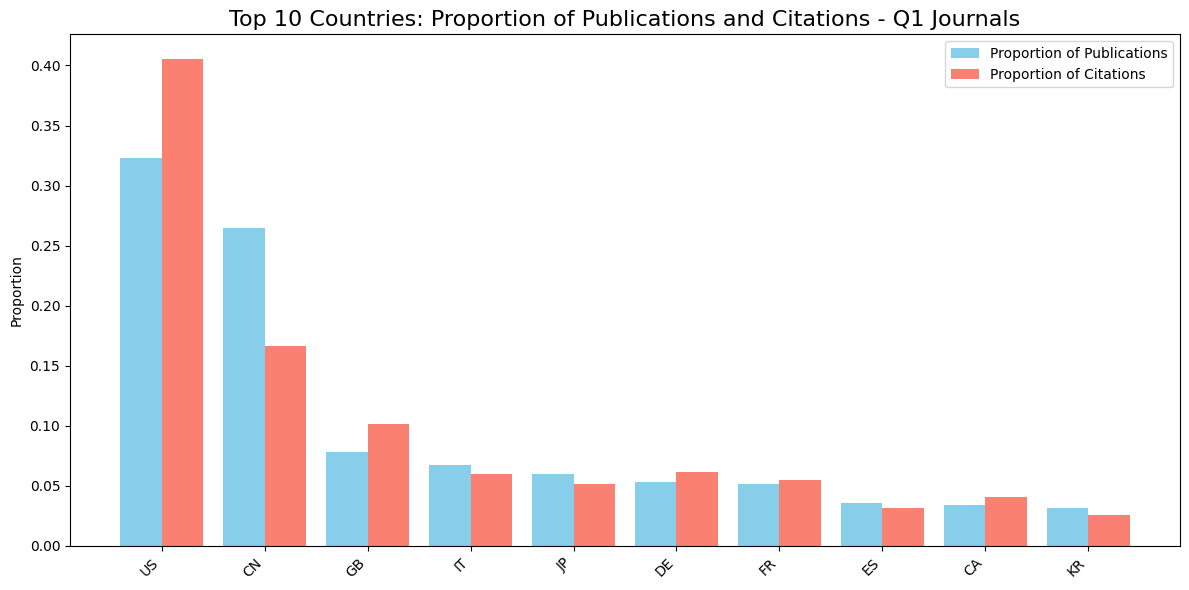

In [11]:
top_countries = (
    group_countries.sort("count", descending=True)
                   .head(10)
                   .select("country_name")
                   .to_series()
                   .to_list()
)

df_top_countries = group_countries.filter(pl.col("country_name").is_in(top_countries)).to_pandas()
df_top_countries_years = group_countriesyears.filter(
    pl.col("country_name").is_in(top_countries)
).to_pandas()

df_top_countries["prop_publications"] = df_top_countries["count"] / df_top_countries["count"].sum()
df_top_countries["prop_citations"] = df_top_countries["cited_by_count_mean"] * df_top_countries["count"]
df_top_countries["prop_citations"] /= df_top_countries["prop_citations"].sum()

fig, ax = plt.subplots(figsize=(12, 6))

width = 0.4
countries = df_top_countries["country_name"]
x = range(len(countries))

ax.bar(x, df_top_countries["prop_publications"], width=width, label="Proportion of Publications", color="skyblue")

ax.bar([i + width for i in x], df_top_countries["prop_citations"], width=width, label="Proportion of Citations", color="salmon")

ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(countries, rotation=45, ha="right")
ax.set_ylabel("Proportion")
ax.set_title("Top 10 Countries: Proportion of Publications and Citations - Q1 Journals", fontsize=16)
ax.legend()
plt.tight_layout()
plt.show()

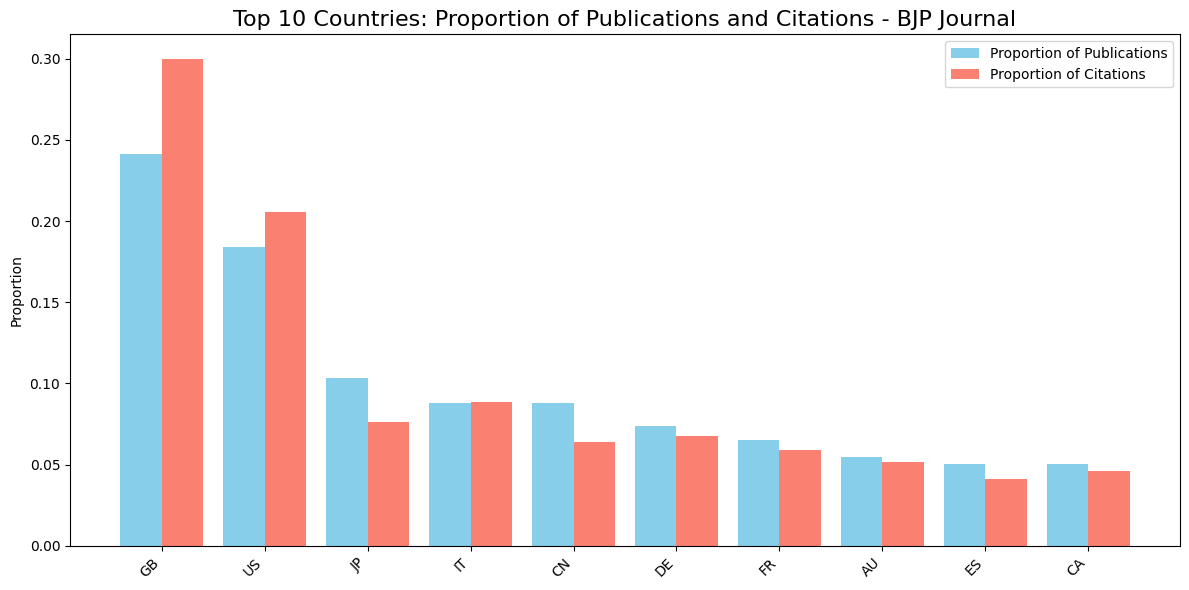

In [12]:
top_countries_bjp = (
    group_countries_bjp.sort("count", descending=True)
                   .head(10)
                   .select("country_name")
                   .to_series()
                   .to_list()
)

df_top_countries = group_countries_bjp.filter(pl.col("country_name").is_in(top_countries_bjp)).to_pandas()
df_top_countries_years = group_countriesyears.filter(
    pl.col("country_name").is_in(top_countries)
).to_pandas()

df_top_countries["prop_publications"] = df_top_countries["count"] / df_top_countries["count"].sum()
df_top_countries["prop_citations"] = df_top_countries["cited_by_count_mean"] * df_top_countries["count"]
df_top_countries["prop_citations"] /= df_top_countries["prop_citations"].sum()

fig, ax = plt.subplots(figsize=(12, 6))

width = 0.4
countries = df_top_countries["country_name"]
x = range(len(countries))

ax.bar(x, df_top_countries["prop_publications"], width=width, label="Proportion of Publications", color="skyblue")

ax.bar([i + width for i in x], df_top_countries["prop_citations"], width=width, label="Proportion of Citations", color="salmon")

ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(countries, rotation=45, ha="right")
ax.set_ylabel("Proportion")
ax.set_title("Top 10 Countries: Proportion of Publications and Citations - BJP Journal", fontsize=16)
ax.legend()
plt.tight_layout()
plt.show()

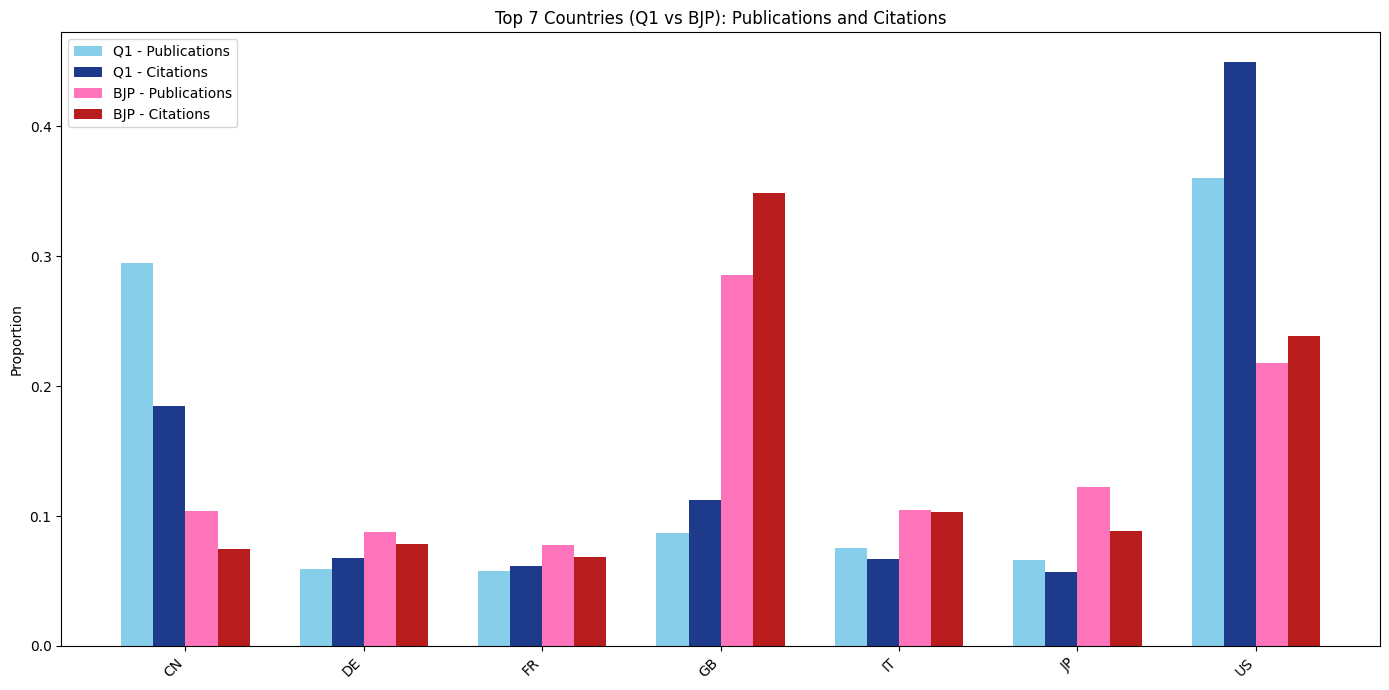

In [13]:
top_countries_q1 = (
    group_countries.sort("count", descending=True)
                   .head(7)
                   .select("country_name")
                   .to_series()
                   .to_list()
)

df_q1 = group_countries.filter(pl.col("country_name").is_in(top_countries_q1)).to_pandas()
df_q1["prop_publications"] = df_q1["count"] / df_q1["count"].sum()
df_q1["prop_citations"] = df_q1["cited_by_count_mean"] * df_q1["count"]
df_q1["prop_citations"] /= df_q1["prop_citations"].sum()
df_q1["source"] = "Q1"

top_countries_bjp = (
    group_countries_bjp.sort("count", descending=True)
                       .head(7)
                       .select("country_name")
                       .to_series()
                       .to_list()
)

df_bjp = group_countries_bjp.filter(pl.col("country_name").is_in(top_countries_bjp)).to_pandas()
df_bjp["prop_publications"] = df_bjp["count"] / df_bjp["count"].sum()
df_bjp["prop_citations"] = df_bjp["cited_by_count_mean"] * df_bjp["count"]
df_bjp["prop_citations"] /= df_bjp["prop_citations"].sum()
df_bjp["source"] = "BJP"

df_all = pd.concat([df_q1, df_bjp], ignore_index=True)

fig, ax = plt.subplots(figsize=(14, 7))

countries = sorted(set(df_all["country_name"]))
x = range(len(countries))
width = 0.18  

def get_vals(df, metric, countries):
    return [df.loc[df["country_name"] == c, metric].values[0] if c in df["country_name"].values else 0 for c in countries]

df_q1_sub = df_all[df_all["source"] == "Q1"]
df_bjp_sub = df_all[df_all["source"] == "BJP"]

ax.bar([i - 1.5*width for i in x], get_vals(df_q1_sub, "prop_publications", countries), 
       width=width, label="Q1 - Publications", color="#87CEEB")  
ax.bar([i - 0.5*width for i in x], get_vals(df_q1_sub, "prop_citations", countries), 
       width=width, label="Q1 - Citations", color="#1E3A8A")  

ax.bar([i + 0.5*width for i in x], get_vals(df_bjp_sub, "prop_publications", countries), 
       width=width, label="BJP - Publications", color="#FD74BB")  
ax.bar([i + 1.5*width for i in x], get_vals(df_bjp_sub, "prop_citations", countries), 
       width=width, label="BJP - Citations", color="#B91C1C")  

ax.set_xticks(list(x))
ax.set_xticklabels(countries, rotation=45, ha="right")
ax.set_ylabel("Proportion")
ax.set_title("Top 7 Countries (Q1 vs BJP): Publications and Citations")
ax.legend()
plt.tight_layout()
plt.show()


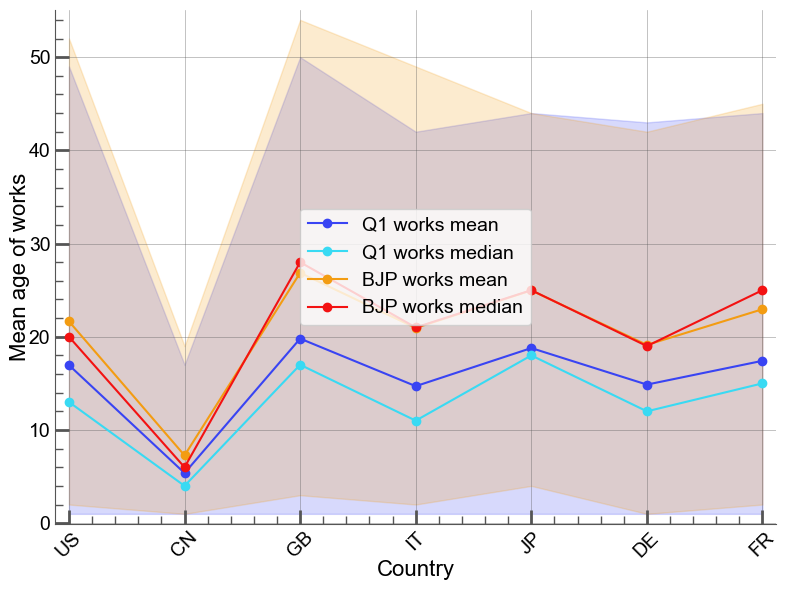

In [14]:

top7_countries = group_countries.head(7)
countries_q1_ci = top7_countries["country_name"].to_list()
mean_q1_ci = top7_countries["age_mean"].to_numpy()
median_q1_ci = top7_countries["age_median"].to_numpy()
low_q1 = top7_countries["age_p2_5"].to_numpy()
high_q1 = top7_countries["age_p97_5"].to_numpy()

top7_countries_bjp = group_countries_bjp.head(7)
bjp_dict = {row["country_name"]: (row["age_mean"], row["age_median"],row["age_p2_5"], row["age_p97_5"]) 
            for row in top7_countries_bjp.to_dicts()}

mean_bjp_ci, median_bjp_ci,low_bjp, high_bjp = [], [], [],[]
for c in countries_q1_ci:
    if c in bjp_dict:
        mean_bjp_ci.append(bjp_dict[c][0])
        median_bjp_ci.append(bjp_dict[c][1])
        low_bjp.append(bjp_dict[c][2])
        high_bjp.append(bjp_dict[c][3])
    else:
        mean_bjp_ci.append(np.nan)
        median_bjp_ci.append(np.nan)
        low_bjp.append(np.nan)
        high_bjp.append(np.nan)

mean_bjp_ci = np.array(mean_bjp_ci)
median_bjp_ci = np.array(median_bjp_ci)
low_bjp = np.array(low_bjp)
high_bjp = np.array(high_bjp)

with aq.load_theme("scientific"):
    plt.figure(figsize=(8,6))

    plt.plot(countries_q1_ci, mean_q1_ci, color="#3944f3", marker="o", label="Q1 works mean")
    plt.plot(countries_q1_ci, median_q1_ci, color="#39daf3", marker="o", label="Q1 works median")
    plt.fill_between(countries_q1_ci, low_q1, high_q1, color="#3944f3", alpha=0.2)

    plt.plot(countries_q1_ci, mean_bjp_ci, color="#f39c12", marker="o", label="BJP works mean")
    plt.plot(countries_q1_ci, median_bjp_ci, color="#f31212", marker="o", label="BJP works median")
    plt.fill_between(countries_q1_ci, low_bjp, high_bjp, color="#f39c12", alpha=0.2)

    plt.xlabel("Country", fontsize=16)
    plt.ylabel("Mean age of works", fontsize=16)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()
    plt.close()  


<Figure size 640x480 with 0 Axes>

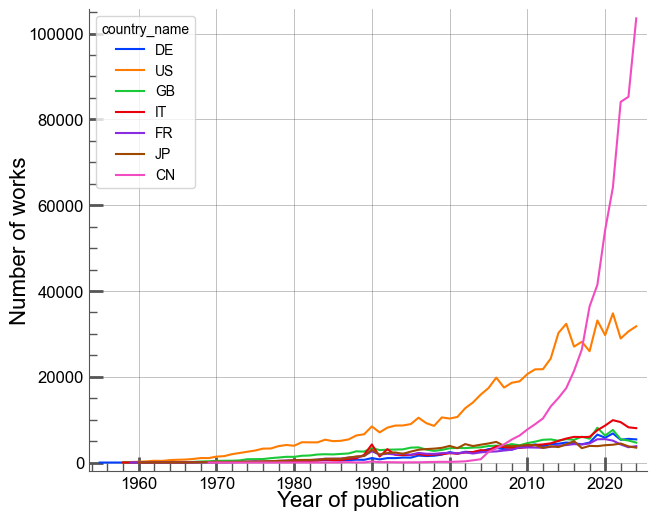

In [15]:

with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    sns.lineplot(data = group_countriesyears.filter(pl.col("country_name").is_in(top_countries_q1)), x = "year", y = "count", hue = "country_name", palette = "bright")
    #plt.xlim(1980, 2024)
    plt.xlabel("Year of publication", fontsize=16)
    plt.ylabel("Number of works", fontsize=16)
    plt.show()

<Figure size 640x480 with 0 Axes>

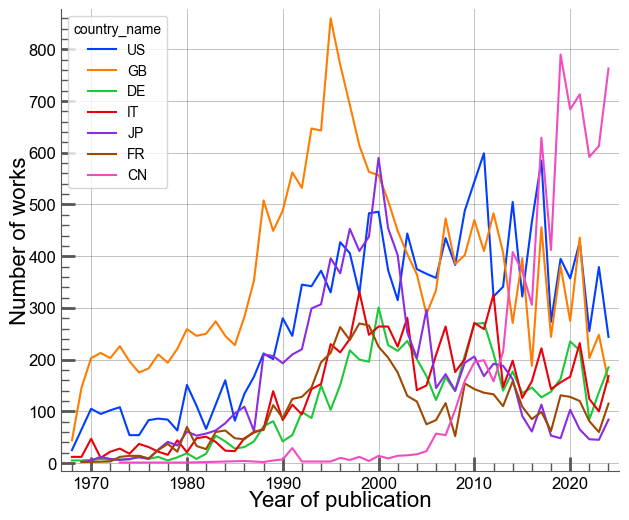

In [16]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    sns.lineplot(data = group_countriesyears_bjp.filter(pl.col("country_name").is_in(top_countries_bjp)), x = "year", y = "count", hue = "country_name", palette = "bright")
    #plt.xlim(1980, 2024)
    plt.xlabel("Year of publication", fontsize=16)
    plt.ylabel("Number of works", fontsize=16)
    plt.show()

<Figure size 640x480 with 0 Axes>

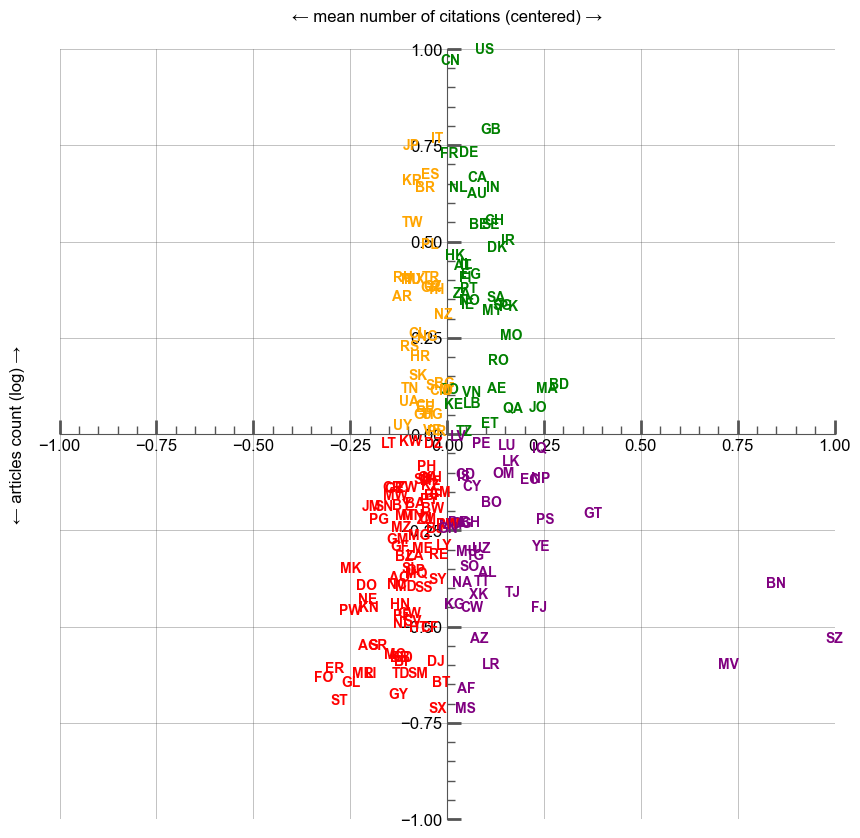

In [17]:
group_countries_filtered = group_countries.filter(pl.col("count") > 5)

group_countries_filtered = group_countries_filtered.with_columns(
    pl.col("count").log().alias("count_log")
)

mean_mncs_mean = group_countries_filtered["mncs_mean"].mean()
group_countries_filtered = group_countries_filtered.with_columns(
    (pl.col("mncs_mean") - mean_mncs_mean).alias("mean_mncs_centered")
)
count_log_max = group_countries_filtered["count_log"].max()
mean_mncs_centered_max = group_countries_filtered["mean_mncs_centered"].abs().max() 

group_countries_filtered = group_countries_filtered.with_columns([
    (-1 + 2 * pl.col("count_log") / count_log_max).alias("count_viz"),
    (pl.col("mean_mncs_centered") / mean_mncs_centered_max).alias("mean_mncs_viz")
])

country_names = group_countries_filtered["country_name"].to_list()
count_viz = group_countries_filtered["count_viz"].to_list()
mean_mncs_viz = group_countries_filtered["mean_mncs_viz"].to_list()

plt.figure(figsize=(10, 10))
for name, x, y in zip(country_names, mean_mncs_viz, count_viz):
    if y >= 0 and x >= 0:
        color = "green"
    elif y >= 0 and x < 0:
        color = "orange"
    elif y < 0 and x < 0:
        color = "red"
    else:  
        color = "purple"
    plt.text(x, y, name, ha="center", va="center", fontsize=10, fontweight="bold", color=color)

plt.xlabel("← mean number of citations (centered) →", labelpad=-320)
plt.ylabel("← articles count (log) →", labelpad=270)
plt.xlim(-1, 1)
plt.ylim(-1, 1)

ax = plt.gca()
ax.spines['left'].set_position('zero')  
ax.spines['bottom'].set_position('zero') 

plt.show()

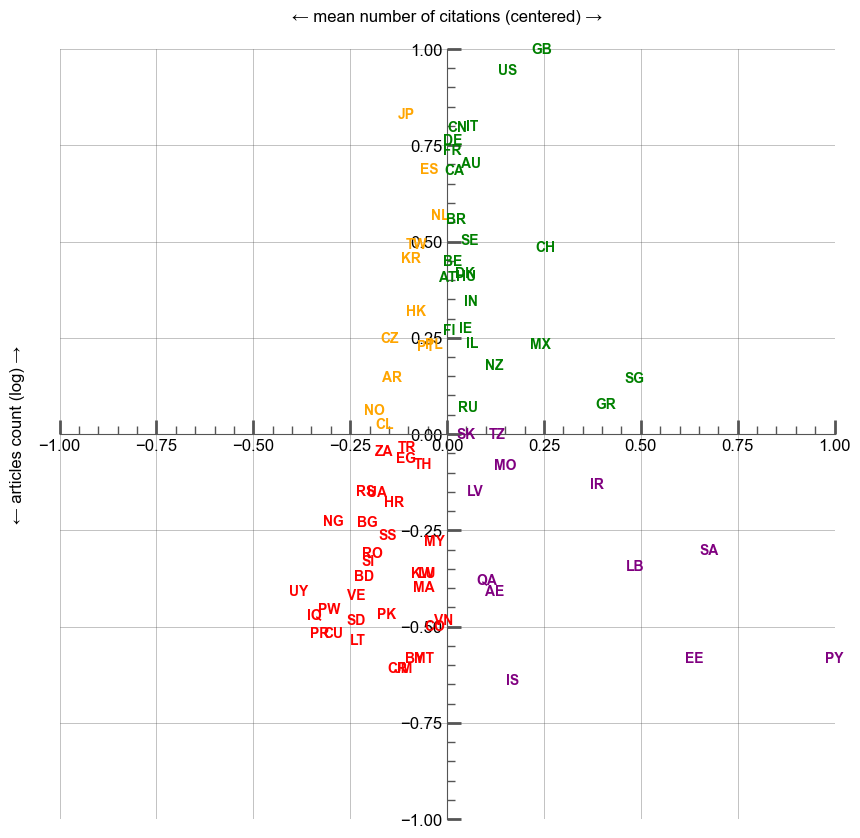

In [18]:
group_countries_filtered = group_countries_bjp.filter(pl.col("count") > 5)

group_countries_filtered = group_countries_filtered.with_columns(
    pl.col("count").log().alias("count_log")
)

mean_mncs_mean = group_countries_filtered["mncs_mean"].mean()
group_countries_filtered = group_countries_filtered.with_columns(
    (pl.col("mncs_mean") - mean_mncs_mean).alias("mean_mncs_centered")
)
count_log_max = group_countries_filtered["count_log"].max()
mean_mncs_centered_max = group_countries_filtered["mean_mncs_centered"].abs().max() 

group_countries_filtered = group_countries_filtered.with_columns([
    (-1 + 2 * pl.col("count_log") / count_log_max).alias("count_viz"),
    (pl.col("mean_mncs_centered") / mean_mncs_centered_max).alias("mean_mncs_viz")
])

country_names = group_countries_filtered["country_name"].to_list()
count_viz = group_countries_filtered["count_viz"].to_list()
mean_mncs_viz = group_countries_filtered["mean_mncs_viz"].to_list()

plt.figure(figsize=(10, 10))
for name, x, y in zip(country_names, mean_mncs_viz, count_viz):
    if y >= 0 and x >= 0:
        color = "green"
    elif y >= 0 and x < 0:
        color = "orange"
    elif y < 0 and x < 0:
        color = "red"
    else:  
        color = "purple"
    plt.text(x, y, name, ha="center", va="center", fontsize=10, fontweight="bold", color=color)

plt.xlabel("← mean number of citations (centered) →", labelpad=-320)
plt.ylabel("← articles count (log) →", labelpad=270)
plt.xlim(-1, 1)
plt.ylim(-1, 1)

ax = plt.gca()
ax.spines['left'].set_position('zero')  
ax.spines['bottom'].set_position('zero') 

plt.show()

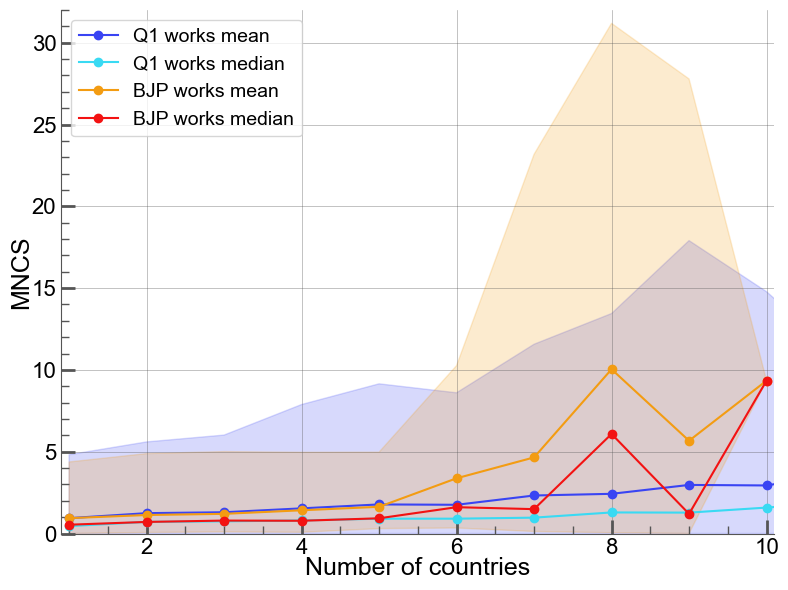

In [19]:


countries_counts_q1 = group_Ncountries["countries_distinct_count"].to_numpy()
mean_q1 = group_Ncountries["mncs_mean"].to_numpy()
median_q1 = group_Ncountries["mncs_median"].to_numpy()
low_q1 = group_Ncountries["mncs_p2_5"].to_numpy()
high_q1 = group_Ncountries["mncs_p97_5"].to_numpy()


countries_counts_bjp = group_Ncountries_bjp["countries_distinct_count"].to_numpy()
mean_bjp = group_Ncountries_bjp["mncs_mean"].to_numpy()
median_bjp = group_Ncountries_bjp["mncs_median"].to_numpy()
low_bjp = group_Ncountries_bjp["mncs_p2_5"].to_numpy()
high_bjp = group_Ncountries_bjp["mncs_p97_5"].to_numpy()

all_counts = sorted(set(countries_counts_q1) | set(countries_counts_bjp))

def align_values(counts, mean,median, low, high, all_counts):
    mean_aligned, median_aligned,low_aligned, high_aligned = [], [], [],[]
    mapping = {c:(m,m2,l,h) for c,m,m2,l,h in zip(counts, mean, median, low, high)}
    for c in all_counts:
        if c in mapping:
            mean_aligned.append(mapping[c][0])
            median_aligned.append(mapping[c][1])
            low_aligned.append(mapping[c][2])
            high_aligned.append(mapping[c][3])
        else:
            mean_aligned.append(np.nan)
            median_aligned.append(np.nan)
            low_aligned.append(np.nan)
            high_aligned.append(np.nan)
    
    return np.array(mean_aligned),np.array(median_aligned), np.array(low_aligned), np.array(high_aligned)

mean_q1, median_q1,low_q1, high_q1 = align_values(countries_counts_q1, mean_q1,median_q1, low_q1, high_q1, all_counts)
mean_bjp, median_bjp, low_bjp, high_bjp = align_values(countries_counts_bjp, mean_bjp,median_bjp, low_bjp, high_bjp, all_counts)


with aq.load_theme("scientific"):
    plt.figure(figsize=(8,6))

    plt.plot(all_counts, mean_q1, color="#3944f3", marker="o", label="Q1 works mean")
    plt.plot(all_counts, median_q1, color="#39daf3", marker="o", label="Q1 works median")
    plt.fill_between(all_counts, low_q1, high_q1, color="#3944f3", alpha=0.2)

    plt.plot(all_counts, mean_bjp, color="#f39c12", marker="o", label="BJP works mean")
    plt.plot(all_counts, median_bjp, color="#f31212", marker="o", label="BJP works median")
    plt.fill_between(all_counts, low_bjp, high_bjp, color="#f39c12", alpha=0.2)

    plt.xlabel("Number of countries", fontsize=18)
    plt.ylabel("MNCS", fontsize=18)
    plt.xlim(0.9, 10.1)
    plt.ylim(0, 32)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()


In [20]:
institutions_col = [f"institution_{i}" for i in range(1, 193)]

institutions = (
    works
    .select(["year", "cited_by_count", "mncs", *institutions_col])  # garder juste ce qui sert
    .sort("year")
    .with_row_index("index_work")
    .unpivot(
        on=institutions_col,
        index=["year", "index_work", "cited_by_count", "mncs"],
        variable_name="institution_pos",
        value_name="institution_name"
    )
    .filter(pl.col("institution_name").is_not_null())
    .with_columns([
        pl.lit(1, dtype=pl.Int8).alias("count"),
        pl.col("institution_name")
          .str.split("',", inclusive=False)
          .list.get(0)
          .str.slice(2)
          .alias("institution_simple")
    ])
)


In [21]:
institutions_col = [f"institution_{i}" for i in range(1, 127)]

institutions_bjp = (
    works_bjp
    .select(["year", "cited_by_count", "mncs", *institutions_col])  # garder juste ce qui sert
    .sort("year")
    .with_row_index("index_work")
    .unpivot(
        on=institutions_col,
        index=["year", "index_work", "cited_by_count", "mncs"],
        variable_name="institution_pos",
        value_name="institution_name"
    )
    .filter(pl.col("institution_name").is_not_null())
    .with_columns([
        pl.lit(1, dtype=pl.Int8).alias("count"),
        pl.col("institution_name")
          .str.split("',", inclusive=False)
          .list.get(0)
          .str.slice(2)
          .alias("institution_simple")
    ])
)


In [22]:
group_institutionsyears = (
    institutions
    .drop("institution_pos")
    .group_by(["institution_simple", "year", "institution_name"]).sum()
    .sort("year")
)
group_institutions_sum = (
    institutions
    .select(["institution_simple", "count", "cited_by_count", "mncs", "institution_name"])
    .group_by(["institution_simple", "institution_name"]).sum()
).sort("cited_by_count", descending=True)

In [23]:
group_institutionsyears_bjp = (
    institutions_bjp
    .drop("institution_pos")
    .group_by(["institution_simple", "year", "institution_name"]).sum()
    .sort("year")
)
group_institutions_sum_bjp = (
    institutions_bjp
    .select(["institution_simple", "count", "cited_by_count", "mncs", "institution_name"])
    .group_by(["institution_simple", "institution_name"]).sum()
).sort("cited_by_count", descending=True)

In [24]:
top_institutions = (
    group_institutions_sum
    .sort("count", descending=True)
    .head(5)
    .select("institution_simple")
    .to_series().to_list()
)
group_institutionsyears = (
    group_institutionsyears
    .with_columns(
        cum_cited_by_count=pl.col("cited_by_count").cum_sum().over("institution_name"),
        cum_mncs=pl.col("mncs").cum_sum().over("institution_name"),
        cum_count=pl.col("count").cum_sum().over("institution_name")
    )
    .with_columns(
        mean_mncs=pl.col("mncs")/pl.col("count"),
        mean_cum_mncs=pl.col("cum_mncs")/pl.col("cum_count")
    )
    .sort("count", descending=True)
)

In [25]:
top_institutions_bjp = (
    group_institutions_sum_bjp
    .sort("count", descending=True)
    .head(5)
    .select("institution_simple")
    .to_series().to_list()
)
group_institutionsyears_bjp = (
    group_institutionsyears_bjp
    .with_columns(
        cum_cited_by_count=pl.col("cited_by_count").cum_sum().over("institution_name"),
        cum_mncs=pl.col("mncs").cum_sum().over("institution_name"),
        cum_count=pl.col("count").cum_sum().over("institution_name")
    )
    .with_columns(
        mean_mncs=pl.col("mncs")/pl.col("count"),
        mean_cum_mncs=pl.col("cum_mncs")/pl.col("cum_count")
    )
    .sort("count", descending=True)
)

In [26]:
cols_to_stats = [
    "cited_by_count",
    "mncs",
    "institutions_distinct_count"
]

agg_exprs = []
for col in cols_to_stats:
    agg_exprs.append(pl.mean(col).alias(f"{col}_mean"))
    agg_exprs.append(pl.median(col).alias(f"{col}_median"))
    agg_exprs.append(pl.col(col).quantile(0.025).alias(f"{col}_p2_5"))
    agg_exprs.append(pl.col(col).quantile(0.975).alias(f"{col}_p97_5"))


group_Ninstitutions = (
    works
    .group_by("institutions_distinct_count")
    .agg(*agg_exprs)
    .sort("institutions_distinct_count")
)

group_Ninstitutions_bjp = (
    works_bjp
    .group_by("institutions_distinct_count")
    .agg(*agg_exprs)
    .sort("institutions_distinct_count")
)

In [27]:
institutions = institutions.sort("index_work").with_columns([
    (pl.col("count").cum_sum().over("institution_name") - pl.col("count")).alias("cumulative_count"),  # over() = operation group by group, like group_by+agg
    (pl.col("cited_by_count").cum_sum().over("institution_name") - pl.col("cited_by_count")).alias("cumulative_citations"),
    (pl.col("mncs").cum_sum().over("institution_name") - pl.col("mncs")).alias("cumulative_mncs")
])

institutions = institutions.with_columns(
    pl.when(pl.col("cumulative_count") == 0)
    .then(pl.lit(1))
    .otherwise(pl.col("cumulative_mncs") / pl.col("cumulative_count"))
    .alias("mean_past_mncs_institutions")
)


In [28]:
institutions_bjp = institutions_bjp.sort("index_work").with_columns([
    (pl.col("count").cum_sum().over("institution_name") - pl.col("count")).alias("cumulative_count"),  # over() = operation group by group, like group_by+agg
    (pl.col("cited_by_count").cum_sum().over("institution_name") - pl.col("cited_by_count")).alias("cumulative_citations"),
    (pl.col("mncs").cum_sum().over("institution_name") - pl.col("mncs")).alias("cumulative_mncs")
])

institutions_bjp = institutions_bjp.with_columns(
    pl.when(pl.col("cumulative_count") == 0)
    .then(pl.lit(1))
    .otherwise(pl.col("cumulative_mncs") / pl.col("cumulative_count"))
    .alias("mean_past_mncs_institutions")
)


In [29]:
institutions_agg = institutions.group_by("index_work").agg([
    pl.col("cumulative_count").mean().alias("mean_past_contributions_institutions"),
    pl.col("mean_past_mncs_institutions").mean().alias("mean_past_mncs_institutions")
])


works = (
    works
    .sort("year")
    .with_row_count("index_work")  # créer l'index si ce n'est pas déjà fait
    .join(institutions_agg, on="index_work", how="left")
    .with_columns([
        pl.col("mean_past_mncs_institutions").fill_null(1),
        pl.col("mean_past_contributions_institutions").fill_null(0)
    ])
)


C:\Users\noahr\AppData\Local\Temp\ipykernel_16696\3828720974.py:10: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  .with_row_count("index_work")  # créer l'index si ce n'est pas déjà fait


In [30]:
institutions_agg_bjp = institutions_bjp.group_by("index_work").agg([
    pl.col("cumulative_count").mean().alias("mean_past_contributions_institutions"),
    pl.col("mean_past_mncs_institutions").mean().alias("mean_past_mncs_institutions")
])


works_bjp = (
    works_bjp
    .sort("year")
    .with_row_count("index_work")  # créer l'index si ce n'est pas déjà fait
    .join(institutions_agg, on="index_work", how="left")
    .with_columns([
        pl.col("mean_past_mncs_institutions").fill_null(1),
        pl.col("mean_past_contributions_institutions").fill_null(0)
    ])
)


C:\Users\noahr\AppData\Local\Temp\ipykernel_16696\3037752234.py:10: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  .with_row_count("index_work")  # créer l'index si ce n'est pas déjà fait


<Figure size 640x480 with 0 Axes>

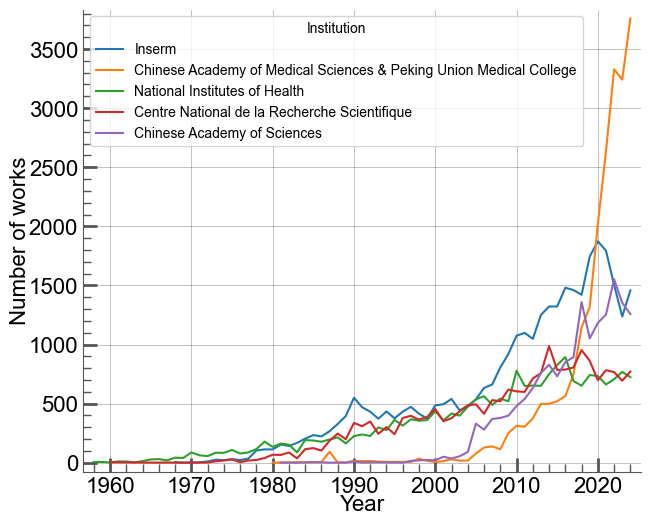

In [31]:
group_filtered = group_institutionsyears.filter( pl.col("institution_simple").is_in(top_institutions) )

group_agg = group_filtered.group_by(["institution_simple", "year"]).agg(
    pl.sum("count").alias("count")
).sort(["institution_simple", "year"])

palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
           "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
           "#bcbd22", "#17becf"]

unique_institutions = top_institutions
institution_colors = {inst: palette[i % len(palette)] for i, inst in enumerate(unique_institutions)}

plt.figure(figsize=(7.2, 6))

for inst in unique_institutions:
    df_inst = group_agg.filter(pl.col("institution_simple") == inst).sort("year")
    plt.plot(df_inst["year"].to_list(), df_inst["count"].to_list(),
             label=inst, color=institution_colors[inst])

plt.ylabel("Number of works", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title="Institution")
plt.show()


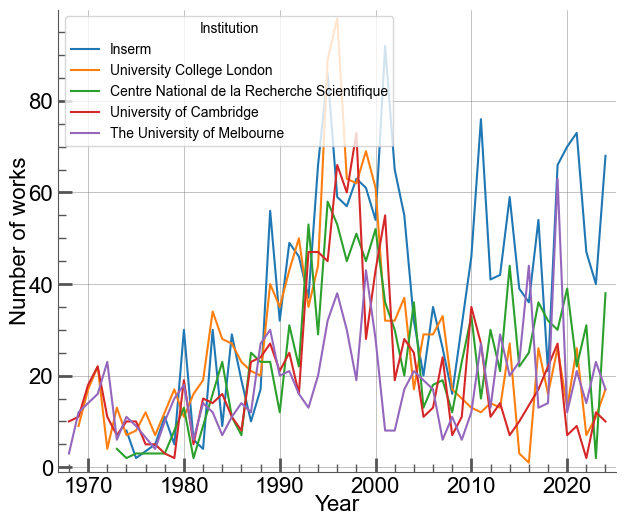

In [32]:
group_filtered = group_institutionsyears_bjp.filter( pl.col("institution_simple").is_in(top_institutions_bjp) )

group_agg = group_filtered.group_by(["institution_simple", "year"]).agg(
    pl.sum("count").alias("count")
).sort(["institution_simple", "year"])

palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
           "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
           "#bcbd22", "#17becf"]

unique_institutions = top_institutions_bjp
institution_colors = {inst: palette[i % len(palette)] for i, inst in enumerate(unique_institutions)}

plt.figure(figsize=(7.2, 6))

for inst in unique_institutions:
    df_inst = group_agg.filter(pl.col("institution_simple") == inst).sort("year")
    plt.plot(df_inst["year"].to_list(), df_inst["count"].to_list(),
             label=inst, color=institution_colors[inst])

plt.ylabel("Number of works", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title="Institution")
plt.show()


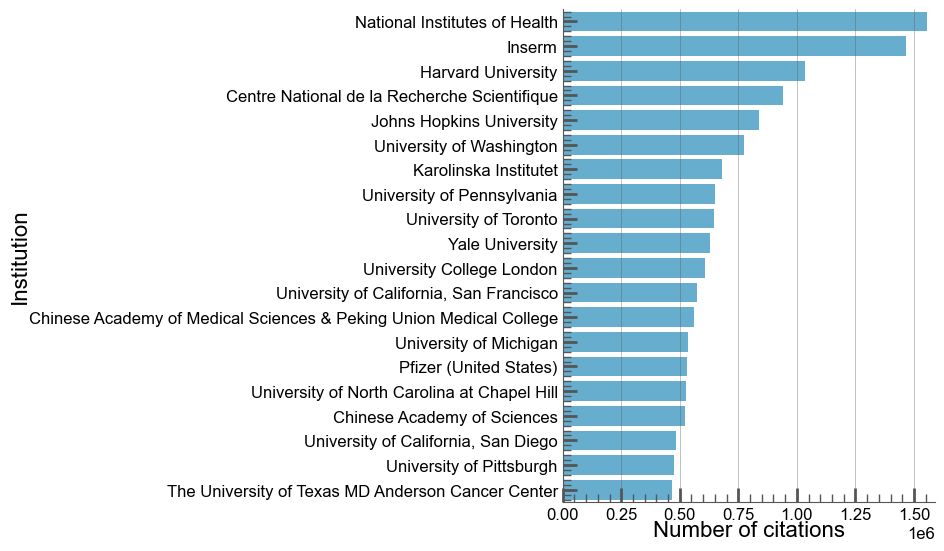

In [33]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(4.8,6.4))
    sns.barplot(data = group_institutions_sum.head(n=20), x = "cited_by_count", y = "institution_simple", orient = "h")
    plt.ylabel("Institution",fontsize=16)
    plt.xlabel("Number of citations", fontsize=16)
    plt.show()

<Figure size 640x480 with 0 Axes>

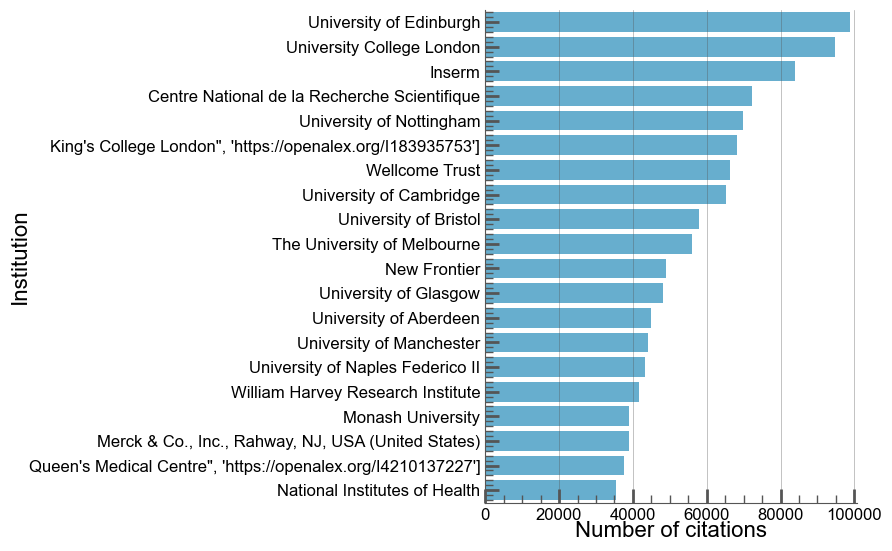

In [34]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(4.8,6.4))
    sns.barplot(data = group_institutions_sum_bjp.head(n=20), x = "cited_by_count", y = "institution_simple", orient = "h")
    plt.ylabel("Institution",fontsize=16)
    plt.xlabel("Number of citations", fontsize=16)
    plt.show()

In [35]:
top_10_universities_names = [
    "Harvard University",
    "University College London",
    "University of Washington",
    "University of Michigan",
    "University of California, San Francisco",
    "University of Toronto",
    "Johns Hopkins University",
    "University of California, San Diego",
    "University of North Carolina at Chapel Hill",
    "University of Pennsylvania"
]

top_10_universities = (
    group_institutions_sum
    .filter(pl.col("institution_simple").is_in(top_10_universities_names))
    .with_columns([pl.lit("University").alias("kind")])
    .drop("institution_name")
)

top_10_universities_bjp = (
    group_institutions_sum_bjp
    .filter(pl.col("institution_simple").is_in(top_10_universities_names))
    .with_columns([pl.lit("University").alias("kind")])
    .drop("institution_name")
)

<Figure size 640x480 with 0 Axes>

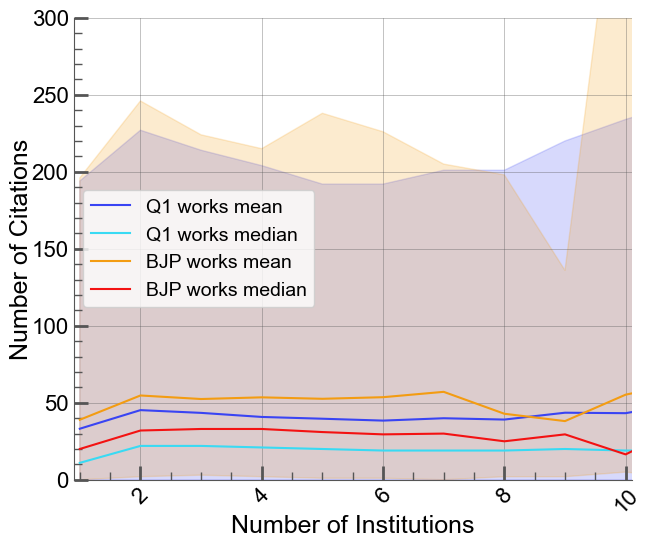

In [36]:
institutions_q1_ci = group_Ninstitutions["institutions_distinct_count"].to_numpy()
mean_q1 = group_Ninstitutions["cited_by_count_mean"].to_numpy()
median_q1 = group_Ninstitutions["cited_by_count_median"].to_numpy()
low_q1 = group_Ninstitutions["cited_by_count_p2_5"].to_numpy()
high_q1 = group_Ninstitutions["cited_by_count_p97_5"].to_numpy()

institutions_bjp_ci = group_Ninstitutions_bjp["institutions_distinct_count"].to_numpy()
mean_bjp = group_Ninstitutions_bjp["cited_by_count_mean"].to_numpy()
median_bjp = group_Ninstitutions_bjp["cited_by_count_median"].to_numpy()
low_bjp = group_Ninstitutions_bjp["cited_by_count_p2_5"].to_numpy()
high_bjp = group_Ninstitutions_bjp["cited_by_count_p97_5"].to_numpy()


with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))

    plt.plot(institutions_q1_ci, mean_q1, color="#3944f3", label="Q1 works mean")
    plt.plot(institutions_q1_ci, median_q1, color="#39daf3",label="Q1 works median")
    plt.fill_between(institutions_q1_ci, low_q1, high_q1, color="#3944f3", alpha=0.2)

    plt.plot(institutions_bjp_ci, mean_bjp, color="#f39c12", label="BJP works mean")
    plt.plot(institutions_bjp_ci, median_bjp, color="#f31212",label="BJP works median")
    plt.fill_between(institutions_bjp_ci, low_bjp, high_bjp, color="#f39c12", alpha=0.2)

    plt.xticks(rotation=45, fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("Number of Institutions", fontsize=18)
    plt.ylabel("Number of Citations", fontsize=18)
    plt.xlim(0.9, 10.1)
    plt.ylim(0, 300)
    plt.legend(fontsize=14)
    plt.show()

<Figure size 640x480 with 0 Axes>

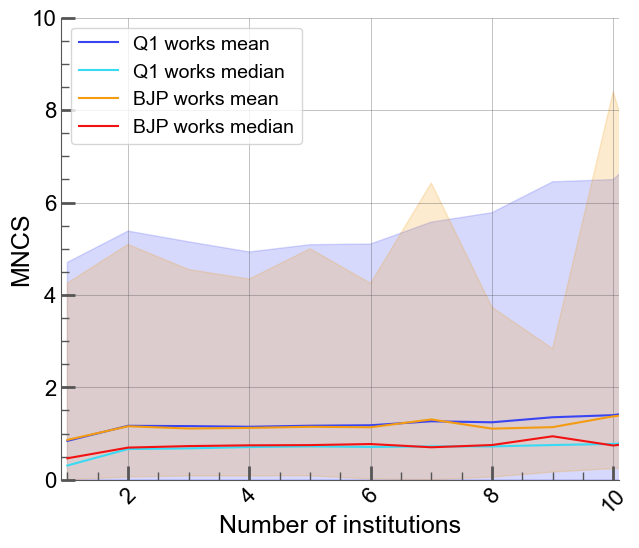

In [37]:
institutions_q1_ci = group_Ninstitutions["institutions_distinct_count"].to_numpy()
mean_q1 = group_Ninstitutions["mncs_mean"].to_numpy()
median_q1 = group_Ninstitutions["mncs_median"].to_numpy()
low_q1 = group_Ninstitutions["mncs_p2_5"].to_numpy()
high_q1 = group_Ninstitutions["mncs_p97_5"].to_numpy()

institutions_bjp_ci = group_Ninstitutions_bjp["institutions_distinct_count"].to_numpy()
mean_bjp = group_Ninstitutions_bjp["mncs_mean"].to_numpy()
median_bjp = group_Ninstitutions_bjp["mncs_median"].to_numpy()
low_bjp = group_Ninstitutions_bjp["mncs_p2_5"].to_numpy()
high_bjp = group_Ninstitutions_bjp["mncs_p97_5"].to_numpy()


with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))

    plt.plot(institutions_q1_ci, mean_q1, color="#3944f3", label="Q1 works mean")
    plt.plot(institutions_q1_ci, median_q1, color="#39daf3",label="Q1 works median")
    plt.fill_between(institutions_q1_ci, low_q1, high_q1, color="#3944f3", alpha=0.2)

    plt.plot(institutions_bjp_ci, mean_bjp, color="#f39c12", label="BJP works mean")
    plt.plot(institutions_bjp_ci, median_bjp, color="#f31212",label="BJP works median")
    plt.fill_between(institutions_bjp_ci, low_bjp, high_bjp, color="#f39c12", alpha=0.2)
    
    plt.xticks(rotation=45, fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("Number of institutions", fontsize=18)
    plt.ylabel("MNCS", fontsize=18)
    plt.xlim(0.9, 10.1)
    plt.ylim(0, 10)
    plt.legend(fontsize=14)
    plt.show()

In [38]:
bigpharma_names = ["Johnson & Johnson",
                    "Roche", 
                    "Merck", # ! Merck & co != Merck KgaA
                    "Pfizer", 
                    "AbbVie",
                    "AstraZeneca",
                    "Novartis", 
                    "Bristol-Myers Squibb",
                    "Eli Lilly",
                    "Sanofi",
                    "Novo Nordisk",
                    "GlaxoSmithKline",
                    "Amgen",
                    "Takeda",
                    "Boehringer Ingelheim",
                    "Gilead Sciences",
                    "Bayer",
                    "Teva Pharmaceuticals",
                    "CSL",
                    "BMS"
                    ] 

starts_with_expression = pl.col("institution_simple").str.starts_with(bigpharma_names[0])
for name in bigpharma_names[1:]:
    starts_with_expression =  starts_with_expression | pl.col("institution_simple").str.starts_with(name)

bigpharma = (
        institutions
        .filter(
            starts_with_expression
        )
        .with_columns(
            (pl.when(pl.col("institution_simple").str.starts_with("Bristol-Myers Squibb")).then(pl.lit("Bristol-Myers Squibb"))
            .otherwise(pl.col("institution_simple").str.replace_all(r"[(–\-)]", ",").str.split(",").list.get(0).str.strip_chars()) #warning: \ before the - otherwise regex think it's a range of character like a-z=alphabet
            .alias("institution_simple"))
        
        )
        .with_columns(
            (pl.when(pl.col("institution_simple").is_in(["Merck & Co.", "Merck Serono", "Merck Canada Inc.", "Merck Institute for Science Education"])).then(pl.lit("Merck"))
            .when(pl.col("institution_simple").is_in(["Pfizer-University of Granada-Junta de Andalucía Centre for Genomics and Oncological Research"])).then(pl.lit("Pfizer"))
            .when(pl.col("institution_simple").is_in(["Novartis Institutes for BioMedical Research", "Novartis Foundation"])).then(pl.lit("Novartis"))
            .when(pl.col("institution_simple").is_in(["Roche Pharma AG"])).then(pl.lit("Roche"))
            .when(pl.col("institution_simple").is_in(["Novo Nordisk Foundation"])).then(pl.lit("Novo Nordisk"))
            .otherwise(pl.col("institution_simple"))
            .alias("institution_simple"))
        
    )
)

bigpharma_bjp = (
        institutions_bjp
        .filter(
            starts_with_expression
        )
        .with_columns(
            (pl.when(pl.col("institution_simple").str.starts_with("Bristol-Myers Squibb")).then(pl.lit("Bristol-Myers Squibb"))
            .otherwise(pl.col("institution_simple").str.replace_all(r"[(–\-)]", ",").str.split(",").list.get(0).str.strip_chars()) #warning: \ before the - otherwise regex think it's a range of character like a-z=alphabet
            .alias("institution_simple"))
        
        )
        .with_columns(
            (pl.when(pl.col("institution_simple").is_in(["Merck & Co.", "Merck Serono", "Merck Canada Inc.", "Merck Institute for Science Education"])).then(pl.lit("Merck"))
            .when(pl.col("institution_simple").is_in(["Pfizer-University of Granada-Junta de Andalucía Centre for Genomics and Oncological Research"])).then(pl.lit("Pfizer"))
            .when(pl.col("institution_simple").is_in(["Novartis Institutes for BioMedical Research", "Novartis Foundation"])).then(pl.lit("Novartis"))
            .when(pl.col("institution_simple").is_in(["Roche Pharma AG"])).then(pl.lit("Roche"))
            .when(pl.col("institution_simple").is_in(["Novo Nordisk Foundation"])).then(pl.lit("Novo Nordisk"))
            .otherwise(pl.col("institution_simple"))
            .alias("institution_simple"))
        
    )
)

bigpharma

shape: (83_563, 12)
┌──────┬────────────┬────────────┬──────────┬───┬────────────┬────────────┬────────────┬───────────┐
│ year ┆ index_work ┆ cited_by_c ┆ mncs     ┆ … ┆ cumulative ┆ cumulative ┆ cumulative ┆ mean_past │
│ ---  ┆ ---        ┆ ount       ┆ ---      ┆   ┆ _count     ┆ _citations ┆ _mncs      ┆ _mncs_ins │
│ i64  ┆ u32        ┆ ---        ┆ f64      ┆   ┆ ---        ┆ ---        ┆ ---        ┆ titutions │
│      ┆            ┆ i64        ┆          ┆   ┆ i64        ┆ i64        ┆ f64        ┆ ---       │
│      ┆            ┆            ┆          ┆   ┆            ┆            ┆            ┆ f64       │
╞══════╪════════════╪════════════╪══════════╪═══╪════════════╪════════════╪════════════╪═══════════╡
│ 1959 ┆ 7227       ┆ 16         ┆ 0.463768 ┆ … ┆ 0          ┆ 0          ┆ 0.0        ┆ 1.0       │
│ 1960 ┆ 7666       ┆ 24         ┆ 0.857821 ┆ … ┆ 1          ┆ 16         ┆ 0.463768   ┆ 0.463768  │
│ 1960 ┆ 7666       ┆ 24         ┆ 0.857821 ┆ … ┆ 2          ┆ 40         ┆ 1.321589   ┆ 0.660794  │
│ 1960 ┆ 7666       ┆ 24         ┆ 0.857821 ┆ … ┆ 3          ┆ 64         ┆ 2.179409   ┆ 0.72647   │
│ 1961 ┆ 8042       ┆ 25         ┆ 0.656194 ┆ … ┆ 0          ┆ 0          ┆ 0.0        ┆ 1.0       │
│ …    ┆ …          ┆ …          ┆ …        ┆ … ┆ …          ┆ …          ┆ …          ┆ …         │
│ 2024 ┆ 689358     ┆ 0          ┆ 0.0      ┆ … ┆ 8748       ┆ 529730     ┆ 13283.2272 ┆ 1.51843   │
│      ┆            ┆            ┆          ┆   ┆            ┆            ┆ 49         ┆           │
│ 2024 ┆ 689358     ┆ 0          ┆ 0.0      ┆ … ┆ 8749       ┆ 529730     ┆ 13283.2272 ┆ 1.518257  │
│      ┆            ┆            ┆          ┆   ┆            ┆            ┆ 49         ┆           │
│ 2024 ┆ 689358     ┆ 0          ┆ 0.0      ┆ … ┆ 8750       ┆ 529730     ┆ 13283.2272 ┆ 1.518083  │
│      ┆            ┆            ┆          ┆   ┆            ┆            ┆ 49         ┆           │
│ 2024 ┆ 689358     ┆ 0          ┆ 0.0      ┆ … ┆ 8751       ┆ 529730     ┆ 13283.2272 ┆ 1.51791   │
│      ┆            ┆            ┆          ┆   ┆            ┆            ┆ 49         ┆           │
│ 2024 ┆ 689358     ┆ 0          ┆ 0.0      ┆ … ┆ 8752       ┆ 529730     ┆ 13283.2272 ┆ 1.517736  │
│      ┆            ┆            ┆          ┆   ┆            ┆            ┆ 49         ┆           │
└──────┴────────────┴────────────┴──────────┴───┴────────────┴────────────┴────────────┴───────────┘

In [39]:
errors = [
    "Rochester General Hospital",
    "Rochester Institute of Technology",
    "Bayero University Kano",
    "Bayerisches Landesamt für Gesundheit und Lebensmittelsicherheit"
]

group_bigpharma = (
    bigpharma
    .drop(["institution_name", "institution_pos"])
    .group_by(by = "institution_simple", maintain_order=True)
    .sum()
    .sort("cited_by_count", descending=True)
    .filter(~(pl.col("by").is_in(errors)))
)

group_bigpharma = group_bigpharma.with_columns(
    kind = pl.lit("Company"),
    institution_simple = pl.col("by")
).drop(["by", "index_work", "year"])

group_bigpharma_bjp = (
    bigpharma_bjp
    .drop(["institution_name", "institution_pos"])
    .group_by(by = "institution_simple", maintain_order=True)
    .sum()
    .sort("cited_by_count", descending=True)
    .filter(~(pl.col("by").is_in(errors)))
)

group_bigpharma_bjp = group_bigpharma_bjp.with_columns(
    kind = pl.lit("Company"),
    institution_simple = pl.col("by")
).drop(["by", "index_work", "year"])

group_bigpharma

shape: (25, 9)
┌────────────┬────────────┬───────┬────────────┬───┬────────────┬────────────┬───────────┬─────────┐
│ cited_by_c ┆ mncs       ┆ count ┆ institutio ┆ … ┆ cumulative ┆ cumulative ┆ mean_past ┆ kind    │
│ ount       ┆ ---        ┆ ---   ┆ n_simple   ┆   ┆ _citations ┆ _mncs      ┆ _mncs_ins ┆ ---     │
│ ---        ┆ f64        ┆ i64   ┆ ---        ┆   ┆ ---        ┆ ---        ┆ titutions ┆ str     │
│ i64        ┆            ┆       ┆ str        ┆   ┆ i64        ┆ f64        ┆ ---       ┆         │
│            ┆            ┆       ┆            ┆   ┆            ┆            ┆ f64       ┆         │
╞════════════╪════════════╪═══════╪════════════╪═══╪════════════╪════════════╪═══════════╪═════════╡
│ 673897     ┆ 16583.0536 ┆ 10901 ┆ Pfizer     ┆ … ┆ 2917388143 ┆ 6.3850e7   ┆ 17934.946 ┆ Company │
│            ┆ 73         ┆       ┆            ┆   ┆            ┆            ┆ 859       ┆         │
│ 549406     ┆ 13565.7853 ┆ 9391  ┆ Merck      ┆ … ┆ 1983509339 ┆ 4.6329e7   ┆ 16297.813 ┆ Company │
│            ┆ 47         ┆       ┆            ┆   ┆            ┆            ┆ 371       ┆         │
│ 545202     ┆ 11950.9729 ┆ 8361  ┆ GlaxoSmith ┆ … ┆ 891726066  ┆ 1.7308e7   ┆ 14010.253 ┆ Company │
│            ┆ 66         ┆       ┆ Kline      ┆   ┆            ┆            ┆ 984       ┆         │
│ 489594     ┆ 11706.4542 ┆ 7847  ┆ Novartis   ┆ … ┆ 780051884  ┆ 1.7161e7   ┆ 12236.333 ┆ Company │
│            ┆ 28         ┆       ┆            ┆   ┆            ┆            ┆ 438       ┆         │
│ 437643     ┆ 10156.3873 ┆ 7038  ┆ Eli Lilly  ┆ … ┆ 1236202849 ┆ 2.8077e7   ┆ 9967.9204 ┆ Company │
│            ┆ 48         ┆       ┆            ┆   ┆            ┆            ┆ 31        ┆         │
│ …          ┆ …          ┆ …     ┆ …          ┆ … ┆ …          ┆ …          ┆ …         ┆ …       │
│ 554        ┆ 15.3286    ┆ 10    ┆ Novo       ┆ … ┆ 2717       ┆ 70.504247  ┆ 15.1178   ┆ Company │
│            ┆            ┆       ┆ Nordisk    ┆   ┆            ┆            ┆           ┆         │
│            ┆            ┆       ┆ Foundation ┆   ┆            ┆            ┆           ┆         │
│            ┆            ┆       ┆ Center…    ┆   ┆            ┆            ┆           ┆         │
│ 114        ┆ 2.84951    ┆ 1     ┆ Rochester  ┆ … ┆ 0          ┆ 0.0        ┆ 1.0       ┆ Company │
│            ┆            ┆       ┆ Institute  ┆   ┆            ┆            ┆           ┆         │
│            ┆            ┆       ┆ of         ┆   ┆            ┆            ┆           ┆         │
│            ┆            ┆       ┆ Technol…   ┆   ┆            ┆            ┆           ┆         │
│ 53         ┆ 1.108824   ┆ 1     ┆ Boehringer ┆ … ┆ 0          ┆ 0.0        ┆ 1.0       ┆ Company │
│            ┆            ┆       ┆ Ingelheim  ┆   ┆            ┆            ┆           ┆         │
│            ┆            ┆       ┆ Foundatio… ┆   ┆            ┆            ┆           ┆         │
│ 24         ┆ 0.432897   ┆ 1     ┆ Bayerische ┆ … ┆ 0          ┆ 0.0        ┆ 1.0       ┆ Company │
│            ┆            ┆       ┆ s          ┆   ┆            ┆            ┆           ┆         │
│            ┆            ┆       ┆ Landesamt  ┆   ┆            ┆            ┆           ┆         │
│            ┆            ┆       ┆ für Umwe…  ┆   ┆            ┆            ┆           ┆         │
│ 8          ┆ 0.213059   ┆ 1     ┆ Rochester  ┆ … ┆ 0          ┆ 0.0        ┆ 1.0       ┆ Company │
│            ┆            ┆       ┆ Center for ┆   ┆            ┆            ┆           ┆         │
│            ┆            ┆       ┆ Behaviora… ┆   ┆            ┆            ┆           ┆         │
└────────────┴────────────┴───────┴────────────┴───┴────────────┴────────────┴───────────┴─────────┘

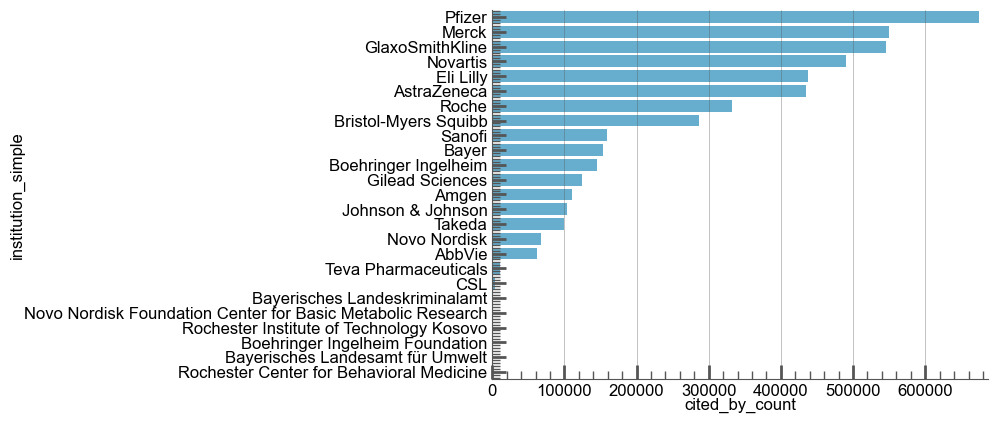

In [40]:
with aq.load_theme("scientific"):
    sns.barplot(data = group_bigpharma, x = "cited_by_count", y = "institution_simple", orient = "h",  legend = True)
    #plt.xticks(rotation = 90)
    plt.show()

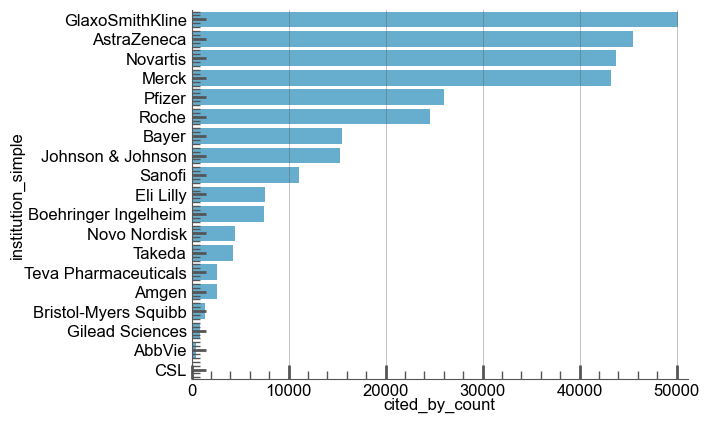

In [41]:
with aq.load_theme("scientific"):
    sns.barplot(data = group_bigpharma_bjp, x = "cited_by_count", y = "institution_simple", orient = "h",  legend = True)
    #plt.xticks(rotation = 90)
    plt.show()

<Figure size 640x480 with 0 Axes>

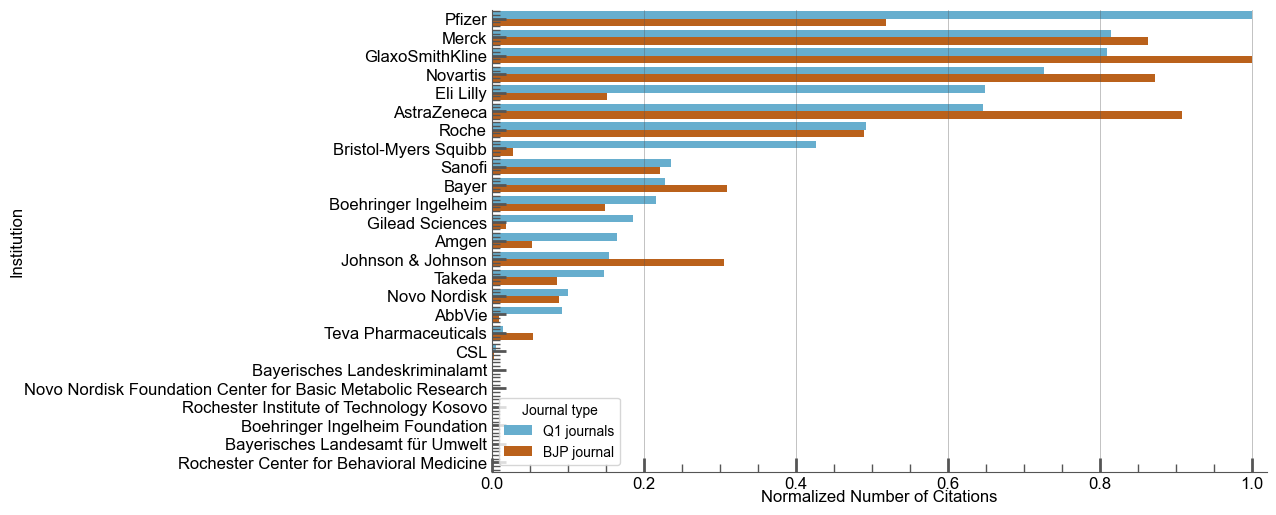

In [42]:

group_bigpharma_norma = group_bigpharma.with_columns(
    (pl.col("cited_by_count") / pl.col("cited_by_count").max()).alias("normalized")
)

group_bigpharma_bjp_norma = group_bigpharma_bjp.with_columns(
    (pl.col("cited_by_count") / pl.col("cited_by_count").max()).alias("normalized")
)

df1 = group_bigpharma_norma.with_columns(pl.lit("Q1 journals").alias("source")).to_pandas()
df2 = group_bigpharma_bjp_norma.with_columns(pl.lit("BJP journal").alias("source")).to_pandas()

df_all = pd.concat([df1, df2], ignore_index=True)

with aq.load_theme("scientific"):
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df_all,
        x="normalized",
        y="institution_simple",
        hue="source",
        orient="h"
    )
    plt.xlabel("Normalized Number of Citations")
    plt.ylabel("Institution")
    plt.legend(title="Journal type")
    plt.show()

In [43]:
group_national_institutions = (
    group_institutions_sum
    .head(4)  # 3 top national institutions but without Harvard
    .filter(pl.col("institution_simple") != "Harvard University")
    .with_columns([pl.lit("National Institution").alias("kind")])
    .drop("institution_name")
)
impact_universities = top_10_universities["cited_by_count"].sum()/top_10_universities["count"].sum()
impact_bigpharma = group_bigpharma["cited_by_count"].sum()/group_bigpharma["count"].sum()
impact_national = group_national_institutions["cited_by_count"].sum()/ group_national_institutions["count"].sum()
print(impact_national)
print(impact_universities)
print(impact_bigpharma)

51.89484697881245
58.98014398924503
57.43421935669431


In [44]:
group_national_institutions_bjp = (
    group_institutions_sum_bjp
    .head(4)  # 3 top national institutions but without Harvard
    .filter(pl.col("institution_simple") != "Harvard University")
    .filter(pl.col("institution_simple") != "University College London")
    .with_columns([pl.lit("National Institution").alias("kind")])
    .drop("institution_name")
)
impact_universities_bjp = top_10_universities_bjp["cited_by_count"].sum()/top_10_universities_bjp["count"].sum()
impact_bigpharma_bjp = group_bigpharma_bjp["cited_by_count"].sum()/group_bigpharma_bjp["count"].sum()
impact_national_bjp = group_national_institutions_bjp["cited_by_count"].sum()/ group_national_institutions_bjp["count"].sum()
print(impact_national_bjp)
print(impact_universities_bjp)
print(impact_bigpharma_bjp)

61.596665055582406
63.478127136021875
70.18053016453382


In [45]:
top_10_universities = (
    group_institutions_sum
    .filter(pl.col("institution_simple").is_in(top_10_universities_names))
    .with_columns([pl.lit("University").alias("kind")])
    .drop("institution_name")
)


group_bigpharma = group_bigpharma.select(top_10_universities.columns)

top_20 = pl.concat([
    top_10_universities.head(7),
    group_bigpharma.head(6),
    group_national_institutions
], how="vertical").sort("cited_by_count", descending=True)


In [46]:
top_10_universities_bjp = (
    group_institutions_sum_bjp
    .filter(pl.col("institution_simple").is_in(top_10_universities_names))
    .with_columns([pl.lit("University").alias("kind")])
    .drop("institution_name")
)


group_bigpharma_bjp = group_bigpharma_bjp.select(top_10_universities.columns)

top_20_bjp = pl.concat([
    top_10_universities_bjp.head(7),
    group_bigpharma_bjp.head(6),
    group_national_institutions_bjp
], how="vertical").sort("cited_by_count", descending=True)


C:\Users\noahr\AppData\Local\Temp\ipykernel_16696\1976038920.py:3: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.barplot(data = top_20, x = "cited_by_count", y = "institution_simple", orient = "h", hue="kind", palette = palette, legend = True)


<Figure size 640x480 with 0 Axes>

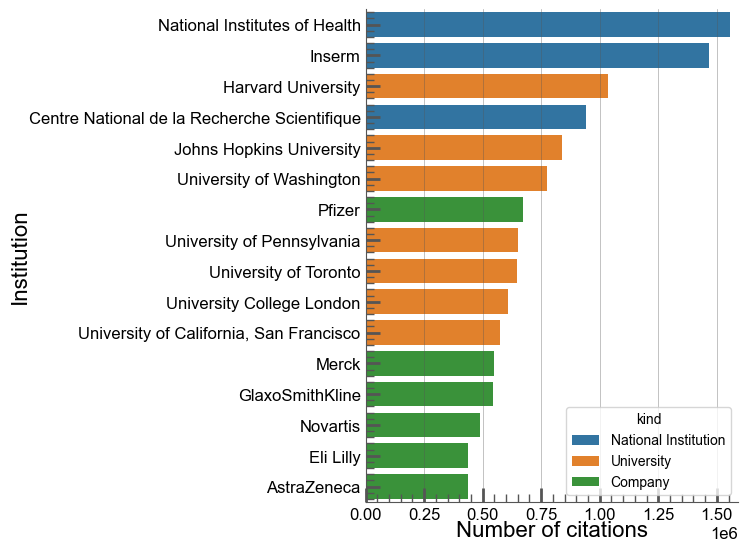

In [47]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(4.8,6.4))
    sns.barplot(data = top_20, x = "cited_by_count", y = "institution_simple", orient = "h", hue="kind", palette = palette, legend = True)
    plt.xlabel("Number of citations", fontsize = 16)
    plt.ylabel("Institution", fontsize=16)
    plt.show()

C:\Users\noahr\AppData\Local\Temp\ipykernel_16696\3286756642.py:3: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.barplot(data = top_20_bjp, x = "cited_by_count", y = "institution_simple", orient = "h", hue="kind", palette = palette, legend = True)


<Figure size 640x480 with 0 Axes>

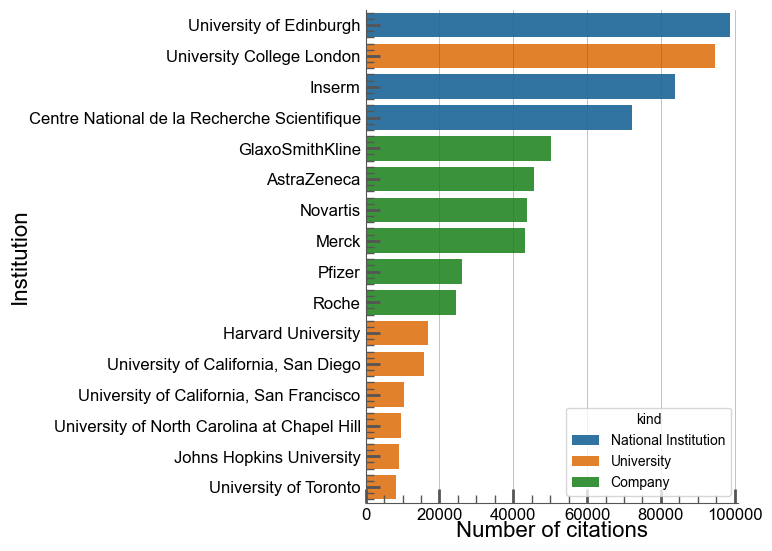

In [48]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(4.8,6.4))
    sns.barplot(data = top_20_bjp, x = "cited_by_count", y = "institution_simple", orient = "h", hue="kind", palette = palette, legend = True)
    plt.xlabel("Number of citations", fontsize = 16)
    plt.ylabel("Institution", fontsize=16)
    plt.show()

In [49]:
means_yearly_citations = [works[f"cited_by_count_{i}"].mean() for i in range(2012, 2025)]
means_yearly_citations_bjp = [works_bjp[f"cited_by_count_{i}"].mean() for i in range(2012, 2025)]

new_studies = works.filter(pl.col("year") == 2012)
means_2012_yearly_citations = [new_studies[f"cited_by_count_{i}"].mean() for i in range(2012, 2025)]
new_studies_bjp = works_bjp.filter(pl.col("year") == 2012)
means_2012_yearly_citations_bjp = [new_studies_bjp[f"cited_by_count_{i}"].mean() for i in range(2012, 2025)]


years = range(13)
years_2012 = range(2012, 2025)

list_means_yearly_citations = []
for year in years:
    new_studies = works.filter(pl.col("year") == 2012 + year)
    list_means_yearly_citations.append([new_studies[f"cited_by_count_{i}"].mean() for i in range(2012 + year, 2025)])

list_means_yearly_citations_bjp = []
for year in years:
    new_studies_bjp = works_bjp.filter(pl.col("year") == 2012 + year)
    list_means_yearly_citations_bjp.append([new_studies_bjp[f"cited_by_count_{i}"].mean() for i in range(2012 + year, 2025)])

<Figure size 640x480 with 0 Axes>

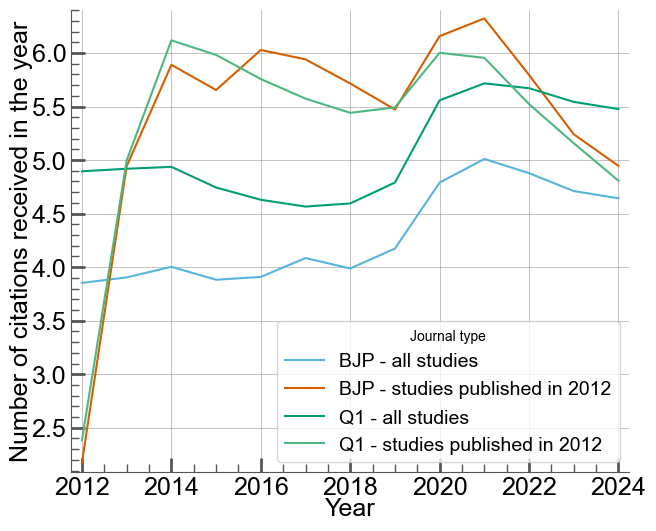

In [50]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))

    # BJP
    sns.lineplot(x=years_2012, y=means_yearly_citations_bjp, label="BJP - all studies")
    sns.lineplot(x=years_2012, y=means_2012_yearly_citations_bjp, label="BJP - studies published in 2012")

    # Q1
    sns.lineplot(x=years_2012, y=means_yearly_citations, label="Q1 - all studies")
    sns.lineplot(x=years_2012, y=means_2012_yearly_citations, label="Q1 - studies published in 2012")

    plt.xlabel("Year", fontsize=18)
    plt.ylabel("Number of citations received in the year", fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=14, title="Journal type")
    plt.show()


In [51]:
number_studies_per_year = (
    works
    .with_columns(pl.lit(1).alias("count"))
    .select(["year", "count"])
    .group_by("year")
    .sum()
    .sort("year")
)

number_studies_per_year_series = pd.Series(
    number_studies_per_year["count"].to_list(),
    index=number_studies_per_year["year"].to_list()
)
number_studies_per_year_series = number_studies_per_year_series.reindex(years_2012, fill_value=0)

number_studies_per_year_series = (number_studies_per_year_series - number_studies_per_year_series.min()) / \
                                 (number_studies_per_year_series.max() - number_studies_per_year_series.min())

means_yearly_citations = []
for year in years_2012:
    new_studies = works.filter(pl.col("year") == year)
    mean_cites = [new_studies[f"cited_by_count_{i}"].mean() for i in range(year, 2025)]
    means_yearly_citations.append(sum(mean_cites)/len(mean_cites)) 

means_yearly_citations_series = pd.Series(means_yearly_citations, index=years_2012)
means_yearly_citations_series = (means_yearly_citations_series - means_yearly_citations_series.min()) / \
                                (means_yearly_citations_series.max() - means_yearly_citations_series.min())


In [52]:
number_studies_per_year_bjp = (
    works_bjp
    .with_columns(pl.lit(1).alias("count"))
    .select(["year", "count"])
    .group_by("year")
    .sum()
    .sort("year")
)

number_studies_per_year_series_bjp = pd.Series(
    number_studies_per_year_bjp["count"].to_list(),
    index=number_studies_per_year_bjp["year"].to_list()
)
number_studies_per_year_series_bjp = number_studies_per_year_series_bjp.reindex(years_2012, fill_value=0)

number_studies_per_year_series_bjp = (number_studies_per_year_series_bjp - number_studies_per_year_series_bjp.min()) / \
                                 (number_studies_per_year_series_bjp.max() - number_studies_per_year_series_bjp.min())

means_yearly_citations_bjp = []
for year in years_2012:
    new_studies_bjp = works_bjp.filter(pl.col("year") == year)
    mean_cites_bjp = [new_studies_bjp[f"cited_by_count_{i}"].mean() for i in range(year, 2025)]
    means_yearly_citations_bjp.append(sum(mean_cites_bjp)/len(mean_cites_bjp)) 

means_yearly_citations_series_bjp = pd.Series(means_yearly_citations_bjp, index=years_2012)
means_yearly_citations_series_bjp = (means_yearly_citations_series_bjp - means_yearly_citations_series_bjp.min()) / \
                                (means_yearly_citations_series_bjp.max() - means_yearly_citations_series_bjp.min())


<Figure size 640x480 with 0 Axes>

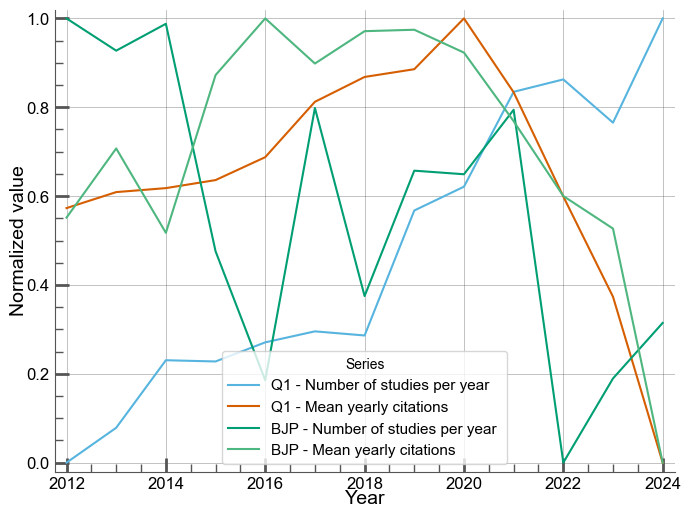

In [53]:
with aq.load_theme("scientific"):
    fig, ax = plt.subplots(figsize=(8,6))

    # Q1
    sns.lineplot(
        x=years_2012,
        y=number_studies_per_year_series.values,
        label="Q1 - Number of studies per year ",
        ax=ax
    )
    sns.lineplot(
        x=years_2012,
        y=means_yearly_citations_series.values,
        label="Q1 - Mean yearly citations ",
        ax=ax
    )

    # BJP
    sns.lineplot(
        x=years_2012,
        y=number_studies_per_year_series_bjp.values,
        label="BJP - Number of studies per year ",
        ax=ax
    )
    sns.lineplot(
        x=years_2012,
        y=means_yearly_citations_series_bjp.values,
        label="BJP - Mean yearly citations ",
        ax=ax
    )

    ax.set_xlabel("Year", fontsize=14)
    ax.set_ylabel("Normalized value", fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend(fontsize=11, title="Series")
    plt.show()
    plt.close()


<Figure size 640x480 with 0 Axes>

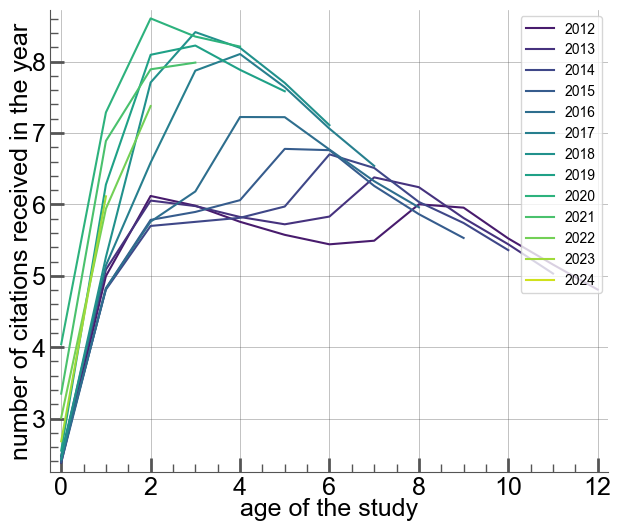

In [54]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    for i in range(13):
        y = list_means_yearly_citations[i]
        sns.lineplot(x = years[:len(y)], y = y, label = f"{2012 + i}", color = sns.set_palette("viridis", n_colors = 13))
    plt.xlabel("age of the study", fontsize=18)
    plt.ylabel("number of citations received in the year", fontsize=18)
    plt.legend()
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

<Figure size 640x480 with 0 Axes>

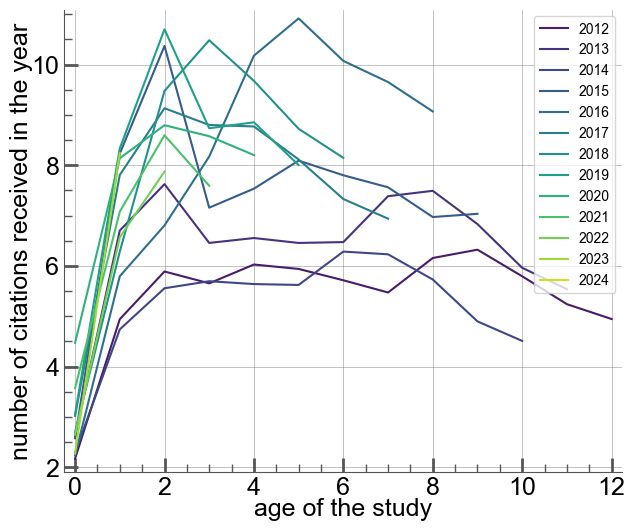

In [55]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    for i in range(13):
        y = list_means_yearly_citations_bjp[i]
        sns.lineplot(x = years[:len(y)], y = y, label = f"{2012 + i}", color = sns.set_palette("viridis", n_colors = 13))
    plt.xlabel("age of the study", fontsize=18)
    plt.ylabel("number of citations received in the year", fontsize=18)
    plt.legend()
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

In [56]:
new_studies = works.filter(pl.col("year") == 2012)


top_studies = new_studies.sort("cited_by_count", descending=True).with_row_index()
superstars = top_studies.filter(pl.col("index")<=85)
stars = top_studies.filter((pl.col("index")>85) & (pl.col("index")<=852))
usual = top_studies.filter(pl.col("index")>852)

superstars_2012_yearly_citations = pd.Series([superstars[f"cited_by_count_{i}"].mean() for i in range(2012, 2025)])
stars_2012_yearly_citations = pd.Series([stars[f"cited_by_count_{i}"].mean() for i in range(2012, 2025)])
usual_2012_yearly_citations = pd.Series([usual[f"cited_by_count_{i}"].mean() for i in range(2012, 2025)])

superstars_2012_yearly_citations = (superstars_2012_yearly_citations - superstars_2012_yearly_citations.min())/(superstars_2012_yearly_citations.max() - superstars_2012_yearly_citations.min())
stars_2012_yearly_citations = (stars_2012_yearly_citations - stars_2012_yearly_citations.min())/(stars_2012_yearly_citations.max() - stars_2012_yearly_citations.min())
usual_2012_yearly_citations = (usual_2012_yearly_citations - usual_2012_yearly_citations.min()) / (usual_2012_yearly_citations.max() - usual_2012_yearly_citations.min())

In [57]:
new_studies_bjp = works_bjp.filter(pl.col("year") == 2012)


top_studies_bjp = new_studies_bjp.sort("cited_by_count", descending=True).with_row_index()
superstars_bjp = top_studies_bjp.filter(pl.col("index")<=85)
stars_bjp = top_studies_bjp.filter((pl.col("index")>85) & (pl.col("index")<=852))
usual_bjp = top_studies_bjp.filter(pl.col("index")>852)

superstars_2012_yearly_citations_bjp = pd.Series([superstars_bjp[f"cited_by_count_{i}"].mean() for i in range(2012, 2025)])
stars_2012_yearly_citations_bjp = pd.Series([stars_bjp[f"cited_by_count_{i}"].mean() for i in range(2012, 2025)])
usual_2012_yearly_citations_bjp = pd.Series([usual_bjp[f"cited_by_count_{i}"].mean() for i in range(2012, 2025)])

superstars_2012_yearly_citations_bjp = (superstars_2012_yearly_citations_bjp - superstars_2012_yearly_citations_bjp.min())/(superstars_2012_yearly_citations_bjp.max() - superstars_2012_yearly_citations_bjp.min())
stars_2012_yearly_citations_bjp = (stars_2012_yearly_citations_bjp - stars_2012_yearly_citations_bjp.min())/(stars_2012_yearly_citations_bjp.max() - stars_2012_yearly_citations_bjp.min())
usual_2012_yearly_citations_bjp = (usual_2012_yearly_citations_bjp - usual_2012_yearly_citations_bjp.min()) / (usual_2012_yearly_citations_bjp.max() - usual_2012_yearly_citations_bjp.min())

<Figure size 640x480 with 0 Axes>

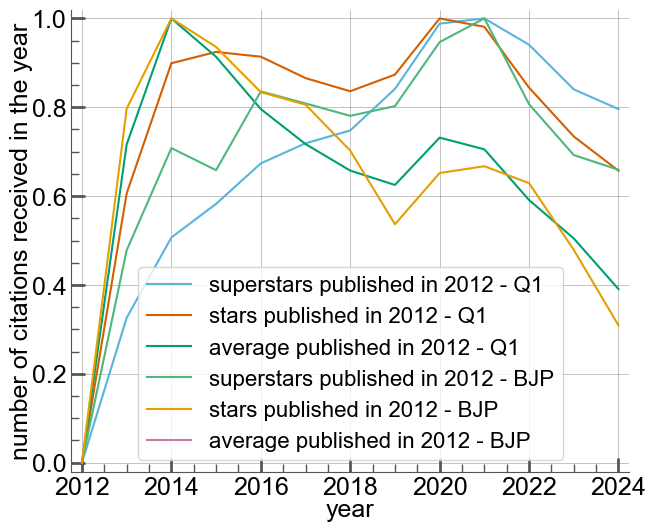

In [58]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    sns.lineplot(x = years_2012, y =  superstars_2012_yearly_citations, label = "superstars published in 2012 - Q1")
    sns.lineplot(x = years_2012, y =  stars_2012_yearly_citations, label = "stars published in 2012 - Q1")
    sns.lineplot(x = years_2012, y =  usual_2012_yearly_citations, label = "average published in 2012 - Q1")
    sns.lineplot(x = years_2012, y =  superstars_2012_yearly_citations_bjp, label = "superstars published in 2012 - BJP")
    sns.lineplot(x = years_2012, y =  stars_2012_yearly_citations_bjp, label = "stars published in 2012 - BJP")
    sns.lineplot(x = years_2012, y =  usual_2012_yearly_citations_bjp, label = "average published in 2012 - BJP")
    plt.xlabel("year", fontsize=18)
    plt.ylabel("number of citations received in the year", fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=16)
    plt.show()

In [59]:
mean_citations = (
    works
    .filter(pl.col("year").is_between(2012, 2024))
    .group_by("year", maintain_order=True)
    .agg(pl.mean("cited_by_count"))
    .sort("year")
)
list_mean_citations = mean_citations.select("cited_by_count").to_series()
list_citation_attention = [ (list_mean_citations[i] - np.cumsum(list_means_yearly_citations[i]))/np.sum(list_means_yearly_citations[i]) for i in range(13)]
list_citation_attention

[array([ 0.65232449,  0.58010594,  0.49167551,  0.40521276,  0.32200892,
         0.24144724,  0.16280313,  0.08342784, -0.00332225, -0.08938715,
        -0.16920992, -0.24375097, -0.31322641]),
 array([ 0.64852967,  0.5712829 ,  0.47937423,  0.38863295,  0.30021029,
         0.21334248,  0.12482907,  0.0279807 , -0.06677312, -0.1549715 ,
        -0.23758541, -0.31398243]),
 array([ 0.59645142,  0.51742493,  0.42374875,  0.32913379,  0.23358267,
         0.1354333 ,  0.02527433, -0.08175277, -0.18094672, -0.27529879,
        -0.36339567]),
 array([ 0.64911769,  0.5631633 ,  0.46014874,  0.35514853,  0.24721374,
         0.12648729,  0.00608082, -0.10541184, -0.20985139, -0.30835155]),
 array([ 0.66699477,  0.5754388 ,  0.46610972,  0.34876134,  0.21162158,
         0.07452222, -0.05396475, -0.17403647, -0.28716306]),
 array([ 0.72939031,  0.62935148,  0.5013297 ,  0.34826193,  0.19068121,
         0.04213985, -0.09512274, -0.22224814]),
 array([ 0.82796871,  0.7155737 ,  0.55095753,  0

In [60]:
mean_citations_bjp = (
    works_bjp
    .filter(pl.col("year").is_between(2012, 2024))
    .group_by("year", maintain_order=True)
    .agg(pl.mean("cited_by_count"))
    .sort("year")
)
list_mean_citations_bjp = mean_citations_bjp.select("cited_by_count").to_series()
list_citation_attention_bjp = [ (list_mean_citations_bjp[i] - np.cumsum(list_means_yearly_citations_bjp[i]))/np.sum(list_means_yearly_citations_bjp[i]) for i in range(13)]
list_citation_attention_bjp

[array([ 0.72243951,  0.65211207,  0.56830902,  0.48785281,  0.40207821,
         0.31754975,  0.23622824,  0.15835876,  0.07074368, -0.01922519,
        -0.10167658, -0.17624836, -0.24661914]),
 array([ 0.73799408,  0.64990856,  0.54971293,  0.46485369,  0.37871898,
         0.29386771,  0.20879197,  0.11173748,  0.01328091, -0.07649234,
        -0.15485519, -0.2276449 ]),
 array([ 0.77377591,  0.69092127,  0.5937813 ,  0.49420051,  0.3956086 ,
         0.29732004,  0.18745066,  0.07852973, -0.02164556, -0.10727583,
        -0.18613305]),
 array([ 0.75592514,  0.6436782 ,  0.50227666,  0.40467377,  0.30192574,
         0.19158565,  0.08520769, -0.01790747, -0.11297431, -0.2089093 ]),
 array([ 0.7677093 ,  0.6881961 ,  0.59484955,  0.48273397,  0.34313587,
         0.19338429,  0.05520578, -0.07720733, -0.20160554]),
 array([ 0.79687052,  0.66656522,  0.51414687,  0.36727387,  0.22089914,
         0.08546161, -0.03686349, -0.15268392]),
 array([ 0.7806814 ,  0.66743382,  0.49665398,  0

<Figure size 640x480 with 0 Axes>

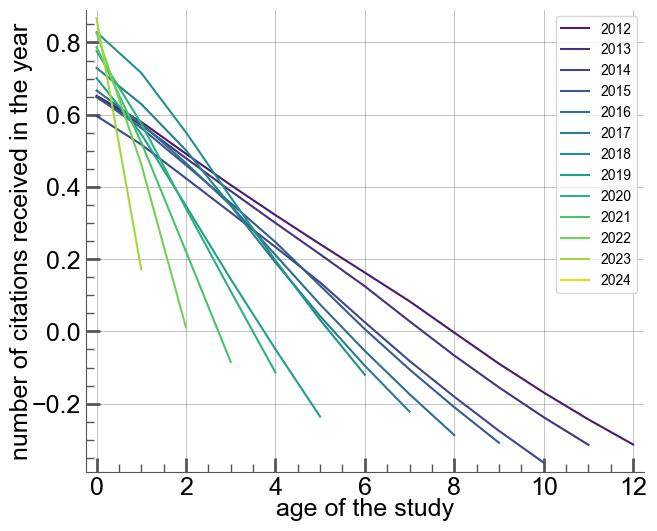

In [61]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    for i in range(13):
        y = list_citation_attention[i]
        sns.lineplot(x = years[:len(y)], y = y, label = f"{2012 + i}", color = sns.set_palette("viridis", n_colors = 13))
    plt.xlabel("age of the study", fontsize=18)
    plt.ylabel("number of citations received in the year", fontsize=18)
    plt.legend()
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

<Figure size 640x480 with 0 Axes>

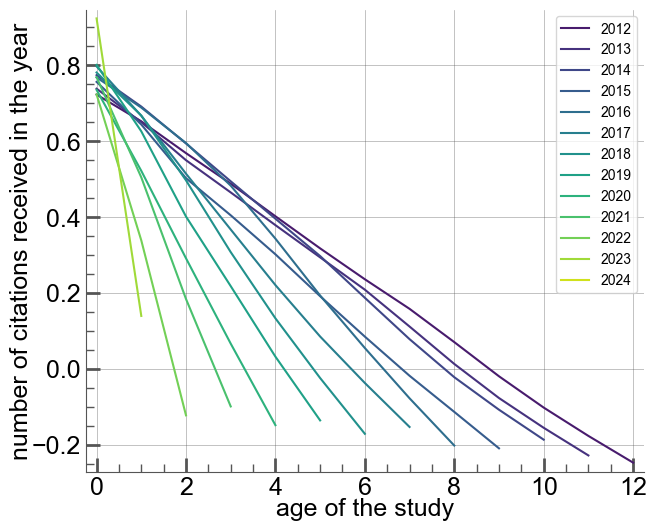

In [62]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    for i in range(13):
        y = list_citation_attention_bjp[i]
        sns.lineplot(x = years[:len(y)], y = y, label = f"{2012 + i}", color = sns.set_palette("viridis", n_colors = 13))
    plt.xlabel("age of the study", fontsize=18)
    plt.ylabel("number of citations received in the year", fontsize=18)
    plt.legend()
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

<Figure size 640x480 with 0 Axes>

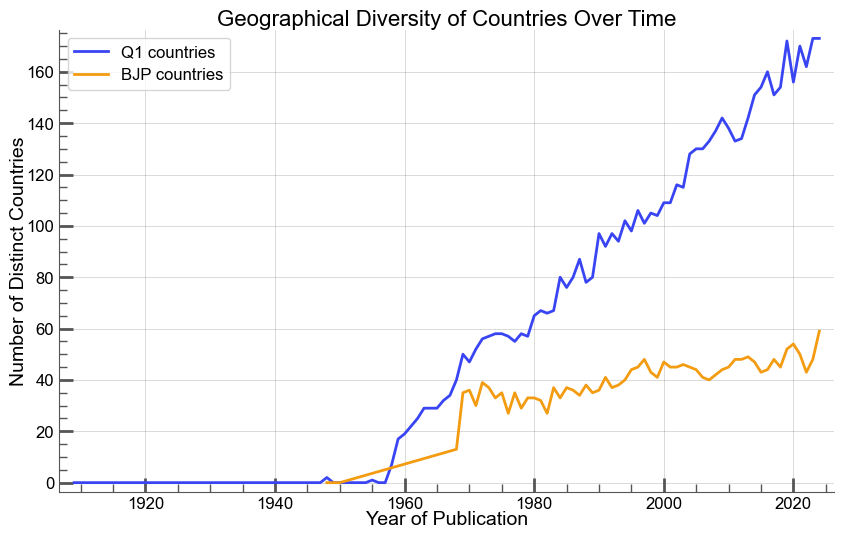

In [63]:
countries_col_q1 = [f"country_{i}" for i in range(1, 193)]
countries_col_bjp = [f"country_{i}" for i in range(1, 121)]

def countries_distinct_yearly_iter(df, countries_col):
    years = sorted(df["year"].unique().to_list())
    countries_count = []

    for y in years:
        df_year = df.filter(pl.col("year") == y)
        # Crée un set vide et ajoute chaque colonne non null
        country_set = set()
        for col in countries_col:
            country_set.update(df_year[col].drop_nulls().to_list())
        countries_count.append(len(country_set))

    return years, countries_count

years_q1, countries_count_q1 = countries_distinct_yearly_iter(works, countries_col_q1)
years_bjp, countries_count_bjp = countries_distinct_yearly_iter(works_bjp, countries_col_bjp)

with aq.load_theme("scientific"):
    plt.figure(figsize=(10,6))
    plt.plot(years_q1, countries_count_q1, color="#3944f3", label="Q1 countries", linewidth=2)
    plt.plot(years_bjp, countries_count_bjp, color="#f39c12", label="BJP countries", linewidth=2)
    plt.xlabel("Year of Publication", fontsize=14)
    plt.ylabel("Number of Distinct Countries", fontsize=14)
    plt.title("Geographical Diversity of Countries Over Time", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

<Figure size 640x480 with 0 Axes>

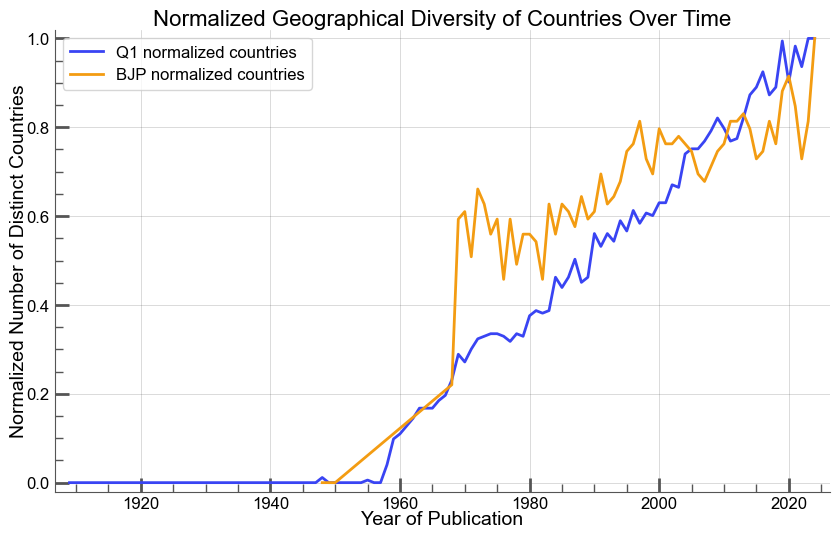

In [64]:
countries_col_q1 = [f"country_{i}" for i in range(1, 193)]
countries_col_bjp = [f"country_{i}" for i in range(1, 121)]

def countries_distinct_yearly_normalized(df, countries_col):
    years = sorted(df["year"].unique().to_list())
    countries_count = []

    for y in years:
        df_year = df.filter(pl.col("year") == y)
        country_set = set()
        for col in countries_col:
            country_set.update(df_year[col].drop_nulls().to_list())
        countries_count.append(len(country_set))

    countries_count = np.array(countries_count, dtype=float)
    countries_count_norm = countries_count / countries_count.max() if countries_count.max() > 0 else countries_count
    return years, countries_count_norm

years_q1, countries_q1_norm = countries_distinct_yearly_normalized(works, countries_col_q1)
years_bjp, countries_bjp_norm = countries_distinct_yearly_normalized(works_bjp, countries_col_bjp)

with aq.load_theme("scientific"):
    plt.figure(figsize=(10,6))
    plt.plot(years_q1, countries_q1_norm, color="#3944f3", label="Q1 normalized countries", linewidth=2)
    plt.plot(years_bjp, countries_bjp_norm, color="#f39c12", label="BJP normalized countries", linewidth=2)
    plt.xlabel("Year of Publication", fontsize=14)
    plt.ylabel("Normalized Number of Distinct Countries", fontsize=14)
    plt.title("Normalized Geographical Diversity of Countries Over Time", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

<Figure size 640x480 with 0 Axes>

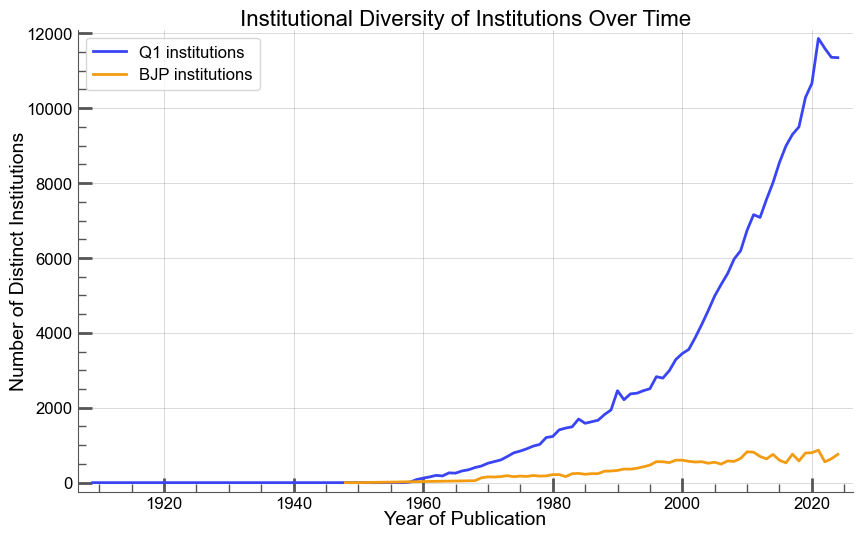

In [65]:


institutions_col_q1 = [f"institution_{i}" for i in range(1, 193)]  # 192 pour Q1
institutions_col_bjp = [f"institution_{i}" for i in range(1, 127)]  # 126 pour BJP

def institutions_distinct_yearly(df, institutions_col):
    years = sorted(df["year"].unique().to_list())
    institutions_count = []

    for y in years:
        df_year = df.filter(pl.col("year") == y)
        inst_set = set()
        for col in institutions_col:
            inst_set.update(df_year[col].drop_nulls().to_list())
        institutions_count.append(len(inst_set))

    return years, institutions_count

years_q1, inst_q1 = institutions_distinct_yearly(works, institutions_col_q1)
years_bjp, inst_bjp = institutions_distinct_yearly(works_bjp, institutions_col_bjp)

with aq.load_theme("scientific"):
    plt.figure(figsize=(10,6))
    plt.plot(years_q1, inst_q1, color="#3944f3", label="Q1 institutions", linewidth=2)
    plt.plot(years_bjp, inst_bjp, color="#f39c12", label="BJP institutions", linewidth=2)
    plt.xlabel("Year of Publication", fontsize=14)
    plt.ylabel("Number of Distinct Institutions", fontsize=14)
    plt.title("Institutional Diversity of Institutions Over Time", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

<Figure size 640x480 with 0 Axes>

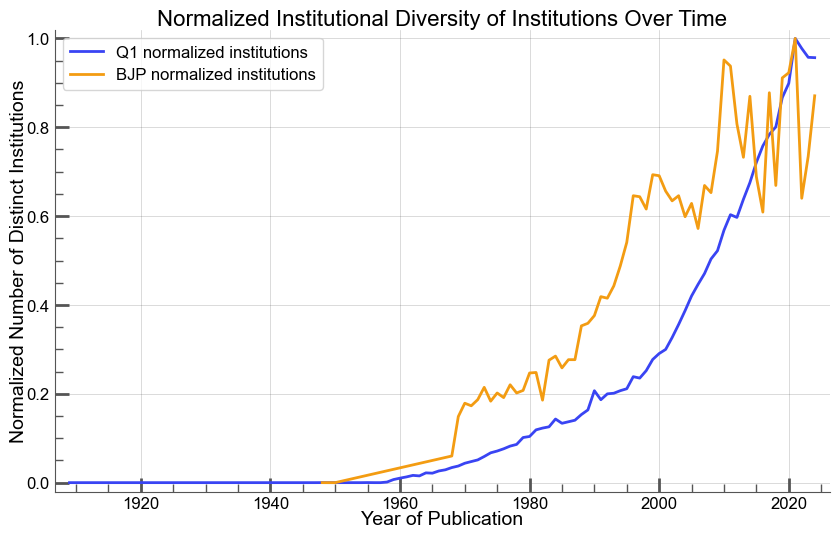

In [66]:

def institutions_distinct_yearly_normalized(df, institutions_col):
    years = sorted(df["year"].unique().to_list())
    institutions_count = []

    for y in years:
        df_year = df.filter(pl.col("year") == y)
        inst_set = set()
        for col in institutions_col:
            inst_set.update(df_year[col].drop_nulls().to_list())
        institutions_count.append(len(inst_set))

    institutions_count = np.array(institutions_count, dtype=float)
    institutions_count_norm = institutions_count / institutions_count.max() if institutions_count.max() > 0 else institutions_count
    return years, institutions_count_norm

years_q1, inst_q1_norm = institutions_distinct_yearly_normalized(works, institutions_col_q1)
years_bjp, inst_bjp_norm = institutions_distinct_yearly_normalized(works_bjp, institutions_col_bjp)

with aq.load_theme("scientific"):
    plt.figure(figsize=(10,6))
    plt.plot(years_q1, inst_q1_norm, color="#3944f3", label="Q1 normalized institutions", linewidth=2)
    plt.plot(years_bjp, inst_bjp_norm, color="#f39c12", label="BJP normalized institutions", linewidth=2)
    plt.xlabel("Year of Publication", fontsize=14)
    plt.ylabel("Normalized Number of Distinct Institutions", fontsize=14)
    plt.title("Normalized Institutional Diversity of Institutions Over Time", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

In [67]:

countries_col_q1 = [f"country_{i}" for i in range(1, 193)]
countries_col_bjp = [f"country_{i}" for i in range(1, 120)]
institutions_col_q1 = [f"institution_{i}" for i in range(1, 193)] 
institutions_col_bjp = [f"institution_{i}" for i in range(1, 127)]  

def collaboration_indicators_safe(df, countries_col, institutions_col, cited_col="cited_by_count"):
    years = sorted(df["year"].unique().to_list())
    pct_multinational = []
    pct_multi_institutional = []
    mean_citations_multi_country = []
    mean_citations_single_country = []

    for y in years:
        df_y = df.filter(pl.col("year") == y)
        n_articles = df_y.height
        multi_country_count = 0
        multi_institution_count = 0
        citations_multi = []
        citations_single = []

        for row in df_y.iter_rows(named=True):
            n_countries = len(set(c for c in (row[c] for c in countries_col) if c is not None))
            n_institutions = len(set(i for i in (row[i] for i in institutions_col) if i is not None))
            cited = row[cited_col]

            if n_countries >= 2:
                multi_country_count += 1
                citations_multi.append(cited)
            else:
                citations_single.append(cited)
            
            if n_institutions >= 2:
                multi_institution_count += 1

        pct_multinational.append((multi_country_count / n_articles *100) if n_articles else 0)
        pct_multi_institutional.append((multi_institution_count / n_articles *100) if n_articles else 0)
        mean_citations_multi_country.append(np.mean(citations_multi) if citations_multi else 0)
        mean_citations_single_country.append(np.mean(citations_single) if citations_single else 0)

    return {
        "year": years,
        "pct_multinational": pct_multinational,
        "pct_multi_institutional": pct_multi_institutional,
        "mean_citations_multi_country": mean_citations_multi_country,
        "mean_citations_single_country": mean_citations_single_country
    }

q1_collab = collaboration_indicators_safe(works, countries_col_q1, institutions_col_q1)
bjp_collab = collaboration_indicators_safe(works_bjp, countries_col_bjp, institutions_col_bjp)




<Figure size 640x480 with 0 Axes>

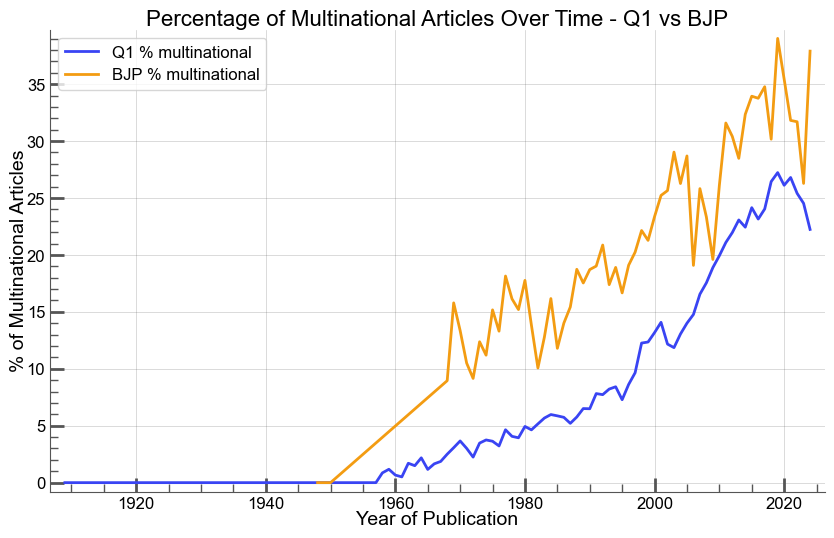

In [68]:
plt.figure(figsize=(10,6))
plt.plot(q1_collab["year"], q1_collab["pct_multinational"], color="#3944f3", label="Q1 % multinational", linewidth=2)
plt.plot(bjp_collab["year"], bjp_collab["pct_multinational"], color="#f39c12", label="BJP % multinational", linewidth=2)
plt.xlabel("Year of Publication", fontsize=14)
plt.ylabel("% of Multinational Articles", fontsize=14)
plt.title("Percentage of Multinational Articles Over Time - Q1 vs BJP", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()





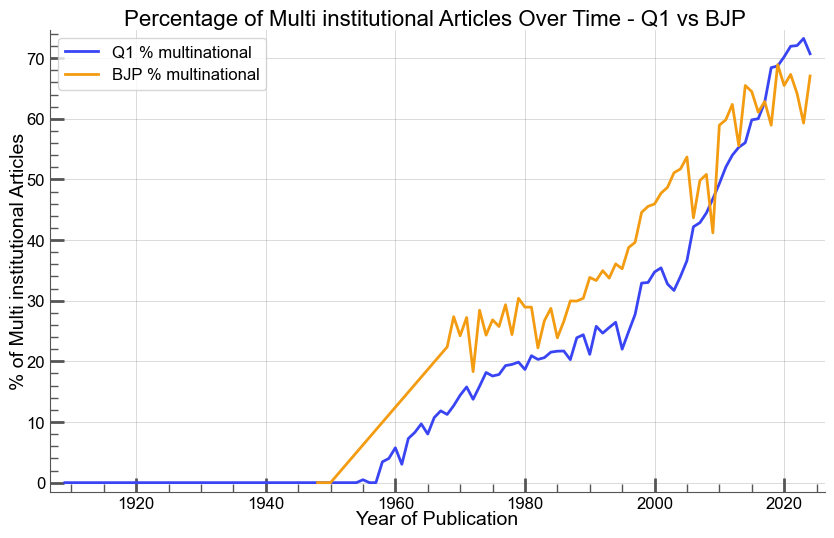

In [69]:

plt.figure(figsize=(10,6))
plt.plot(q1_collab["year"], q1_collab["pct_multi_institutional"], color="#3944f3", label="Q1 % multinational", linewidth=2)
plt.plot(bjp_collab["year"], bjp_collab["pct_multi_institutional"], color="#f39c12", label="BJP % multinational", linewidth=2)
plt.xlabel("Year of Publication", fontsize=14)
plt.ylabel("% of Multi institutional Articles", fontsize=14)
plt.title("Percentage of Multi institutional Articles Over Time - Q1 vs BJP ", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

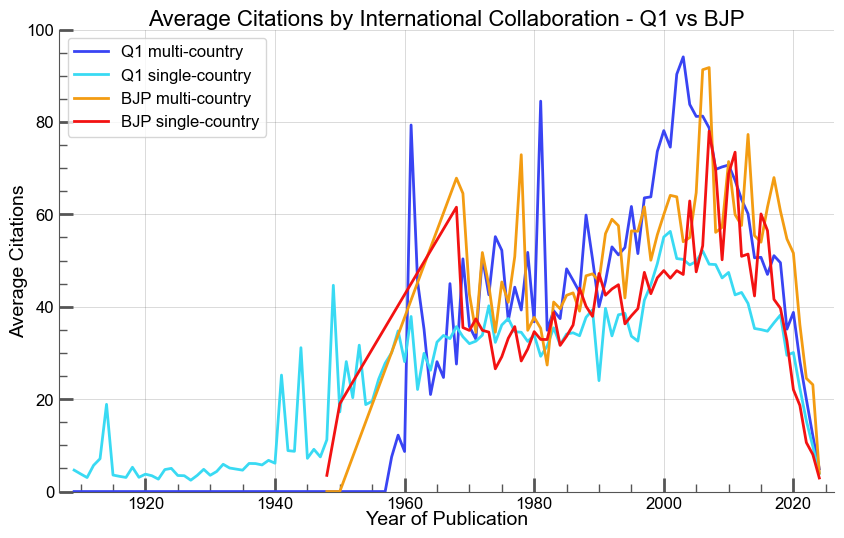

In [70]:
plt.figure(figsize=(10,6))
plt.plot(q1_collab["year"], q1_collab["mean_citations_multi_country"], color="#3944f3", label="Q1 multi-country", linewidth=2)
plt.plot(q1_collab["year"], q1_collab["mean_citations_single_country"], color="#39daf3", label="Q1 single-country", linewidth=2)
plt.plot(bjp_collab["year"], bjp_collab["mean_citations_multi_country"], color="#f39c12", label="BJP multi-country", linewidth=2)
plt.plot(bjp_collab["year"], bjp_collab["mean_citations_single_country"], color="#f31212", label="BJP single-country", linewidth=2)
plt.xlabel("Year of Publication", fontsize=14)
plt.ylabel("Average Citations", fontsize=14)
plt.ylim(0, 100)
plt.title("Average Citations by International Collaboration - Q1 vs BJP", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

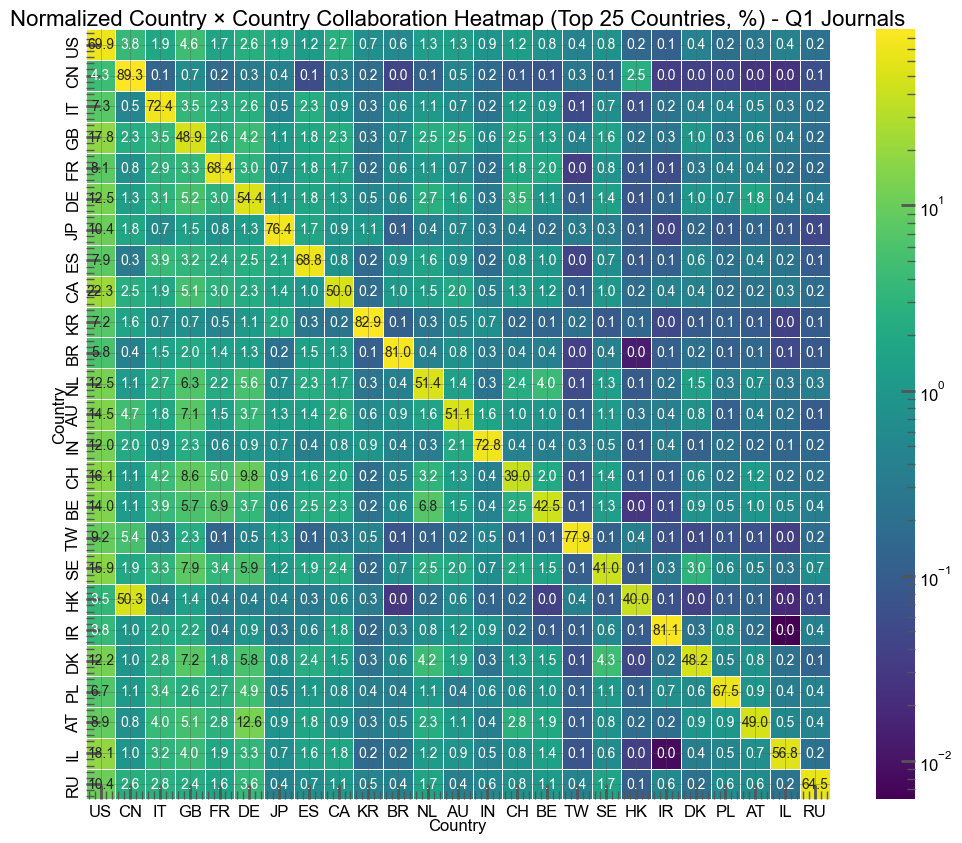

In [71]:

import itertools
import matplotlib

countries_col_q1 = [f"country_{i}" for i in range(1, 193)]

pairs_counter = {}
country_collab_totals = {}

for row in works.select(countries_col_q1).iter_rows(named=True):
    countries = [row[c] for c in countries_col_q1 if row[c] is not None]
    if len(countries) >= 2:
        for pair in itertools.combinations(sorted(countries), 2):
            pairs_counter[pair] = pairs_counter.get(pair, 0) + 1
            country_collab_totals[pair[0]] = country_collab_totals.get(pair[0], 0) + 1
            country_collab_totals[pair[1]] = country_collab_totals.get(pair[1], 0) + 1

top_countries = sorted(country_collab_totals.items(), key=lambda x: x[1], reverse=True)[:25]
top_countries = [c for c, _ in top_countries]

top2_countries = sorted(country_collab_totals.items(), key=lambda x: x[1], reverse=True)
top2_countries = [c for c, _ in top2_countries]

heatmap_df = pd.DataFrame(0, index=top_countries, columns=top_countries, dtype=float)

for (c1, c2), count in pairs_counter.items():
    if c1 in top_countries and c2 in top_countries:
        heatmap_df.loc[c1, c2] = count
        heatmap_df.loc[c2, c1] = count  

for c in top_countries:
    total = heatmap_df.loc[c, :].sum()
    if total > 0:
        heatmap_df.loc[c, :] = heatmap_df.loc[c, :] / total * 100  

plt.figure(figsize=(12,10))

sns.heatmap(
    heatmap_df,
    cmap="viridis",          
    norm=matplotlib.colors.LogNorm(vmin=heatmap_df[heatmap_df > 0].min().min(),
                                   vmax=heatmap_df.max().max()),  
    linewidths=0.5,
    annot=True,
    fmt=".1f"
)

plt.title("Normalized Country × Country Collaboration Heatmap (Top 25 Countries, %) - Q1 Journals", fontsize=16)
plt.xlabel("Country")
plt.ylabel("Country")
plt.show()


C:\Users\noahr\AppData\Local\Temp\ipykernel_16696\3471440574.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")


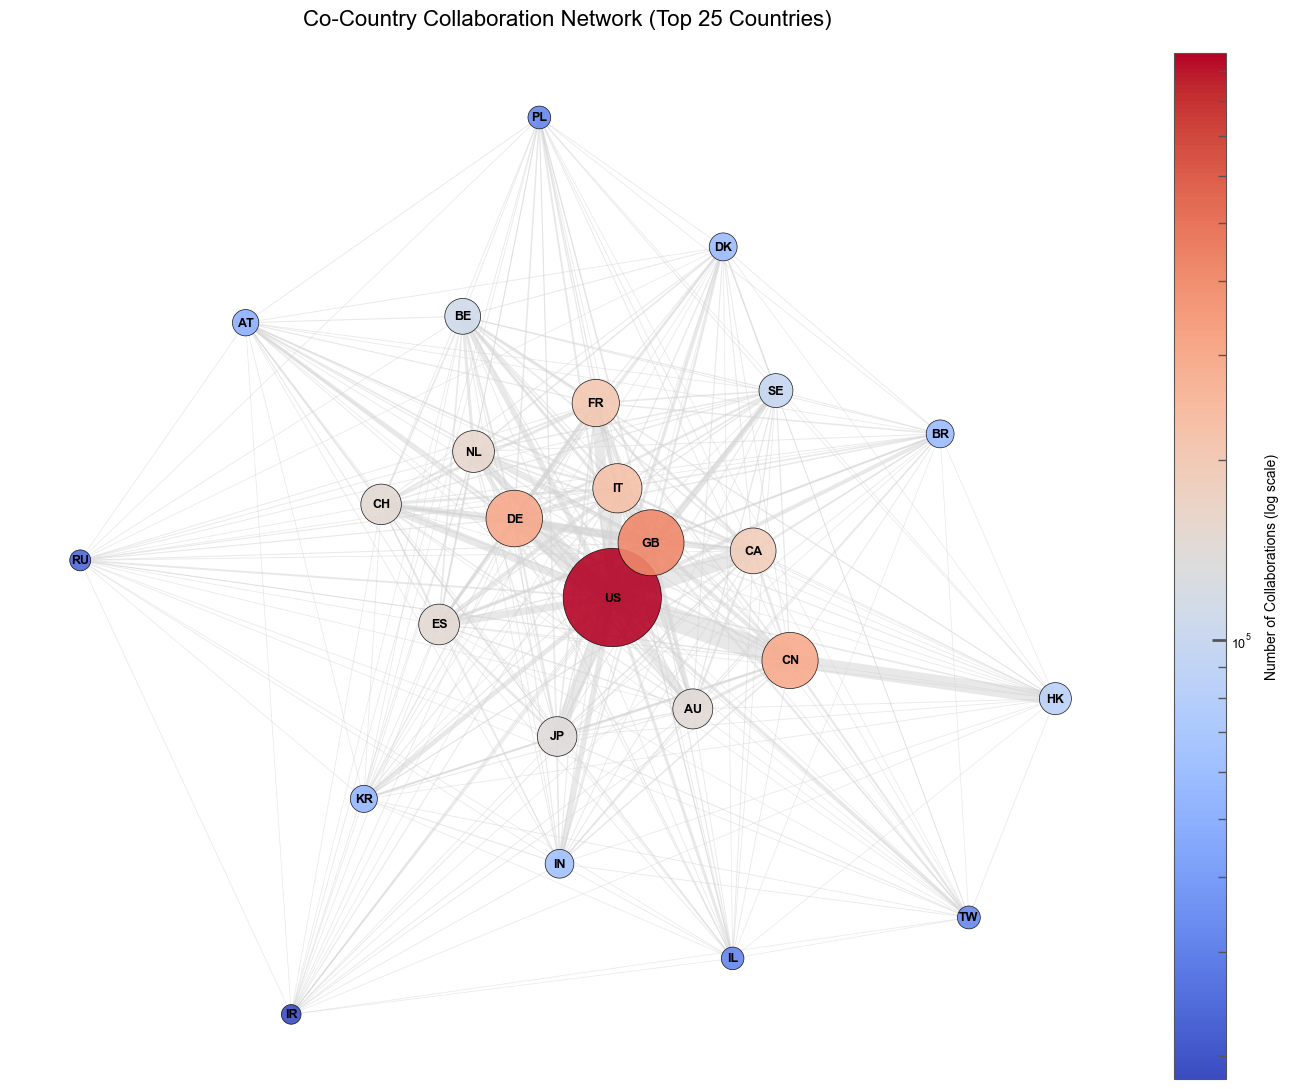

In [72]:
import networkx as nx
import matplotlib.cm as cm
import matplotlib.colors as mcolors

G = nx.Graph()
for (c1, c2), count in pairs_counter.items():
    if c1 != c2 and c1 in top_countries and c2 in top_countries:
        G.add_edge(c1, c2, weight=count)

node_vals = np.array([deg for node, deg in G.degree(weight='weight')])
node_sizes = 200 + (node_vals - node_vals.min()) / (node_vals.max() - node_vals.min() + 1e-9) * (5000 - 200)  

edge_vals = np.array([G[u][v]['weight'] for u, v in G.edges()])
edge_weights = 0.5 + (edge_vals - edge_vals.min()) / (edge_vals.max() - edge_vals.min() + 1e-9) * (20 - 0.5)  # 0.5 à 5 px



cmap = cm.get_cmap("coolwarm")

norm = mcolors.LogNorm(vmin=node_vals.min() + 1e-9, vmax=node_vals.max())

colors = cmap(norm(node_vals))

pos = nx.spring_layout(G, k=1.1, weight='weight', seed=42)

fig, ax = plt.subplots(figsize=(13, 11))

nx.draw_networkx_edges(
    G, pos,
    ax=ax,
    width=edge_weights,
    edge_color='lightgray',
    alpha=0.5
)

nx.draw_networkx_nodes(
    G, pos,
    ax=ax,
    node_size=node_sizes,
    node_color=colors,
    alpha=0.9,
    edgecolors='black',
    linewidths=0.5
)

nx.draw_networkx_labels(
    G, pos,
    ax=ax,
    font_size=9,
    font_weight='bold'
)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=9)
cbar.set_label("Number of Collaborations (log scale)", fontsize=10, labelpad=10)

ax.set_title("Co-Country Collaboration Network (Top 25 Countries)", fontsize=16, pad=20)
ax.axis("off")
plt.tight_layout()
plt.show()


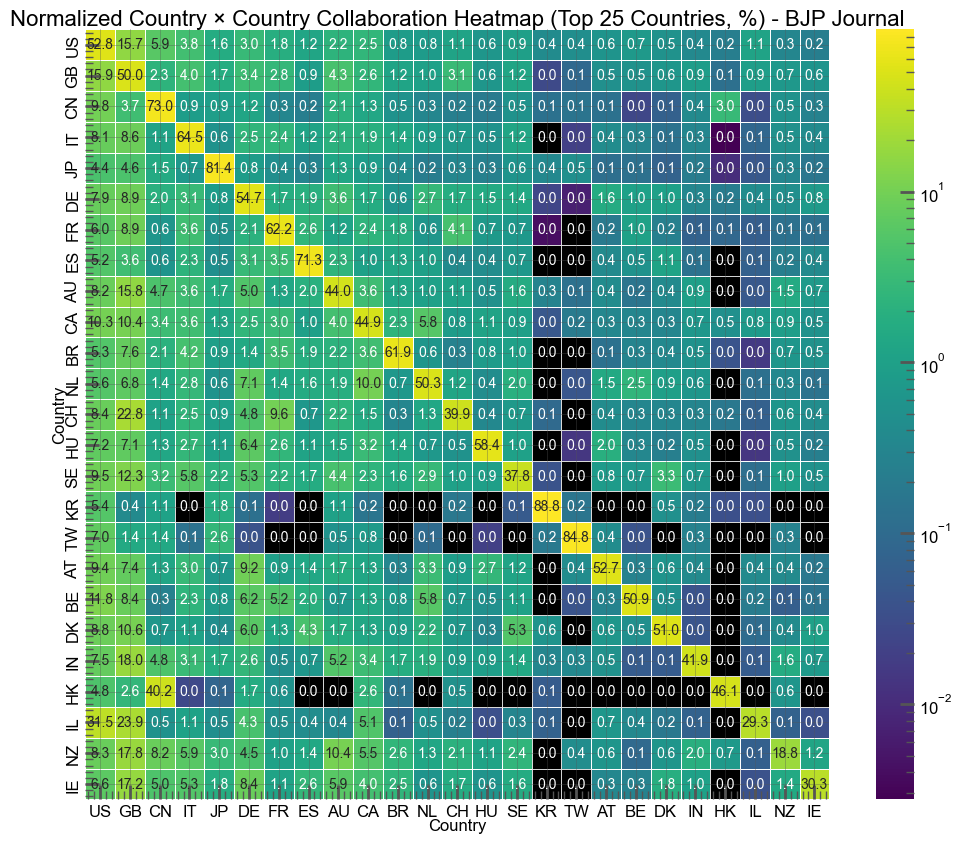

In [73]:
countries_col_bjp = [f"country_{i}" for i in range(1, 121)]

pairs_counter = {}
country_collab_totals = {}

for row in works_bjp.select(countries_col_bjp).iter_rows(named=True):
    countries = [row[c] for c in countries_col_bjp if row[c] is not None]
    if len(countries) >= 2:
        for pair in itertools.combinations(sorted(countries), 2):
            pairs_counter[pair] = pairs_counter.get(pair, 0) + 1
            country_collab_totals[pair[0]] = country_collab_totals.get(pair[0], 0) + 1
            country_collab_totals[pair[1]] = country_collab_totals.get(pair[1], 0) + 1

top_countries = sorted(country_collab_totals.items(), key=lambda x: x[1], reverse=True)[:25]
top_countries = [c for c, _ in top_countries]

top2_countries = sorted(country_collab_totals.items(), key=lambda x: x[1], reverse=True)
top2_countries = [c for c, _ in top2_countries]

heatmap_df = pd.DataFrame(0, index=top_countries, columns=top_countries, dtype=float)

for (c1, c2), count in pairs_counter.items():
    if c1 in top_countries and c2 in top_countries:
        heatmap_df.loc[c1, c2] = count
        heatmap_df.loc[c2, c1] = count  

for c in top_countries:
    total = heatmap_df.loc[c, :].sum()
    if total > 0:
        heatmap_df.loc[c, :] = heatmap_df.loc[c, :] / total * 100  

plt.figure(figsize=(12,10))

mask = (heatmap_df == 0)

ax = sns.heatmap(
    heatmap_df,
    cmap="viridis",
    norm=matplotlib.colors.LogNorm(
        vmin=heatmap_df[heatmap_df > 0].min().min(),
        vmax=heatmap_df.max().max()
    ),
    linewidths=0.5,
    linecolor="white",      
    annot=True,
    fmt=".1f",
    mask=mask,
)

for i in range(heatmap_df.shape[0]):
    for j in range(heatmap_df.shape[1]):
        if heatmap_df.iloc[i, j] == 0:
            rect = plt.Rectangle((j, i), 1, 1, facecolor="black", edgecolor="white", lw=0.5)
            ax.add_patch(rect)
            ax.text(j + 0.5, i + 0.5, "0.0", ha="center", va="center", color="white")

plt.title("Normalized Country × Country Collaboration Heatmap (Top 25 Countries, %) - BJP Journal", fontsize=16)
plt.xlabel("Country")
plt.ylabel("Country")
plt.show()




C:\Users\noahr\AppData\Local\Temp\ipykernel_16696\263753294.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")


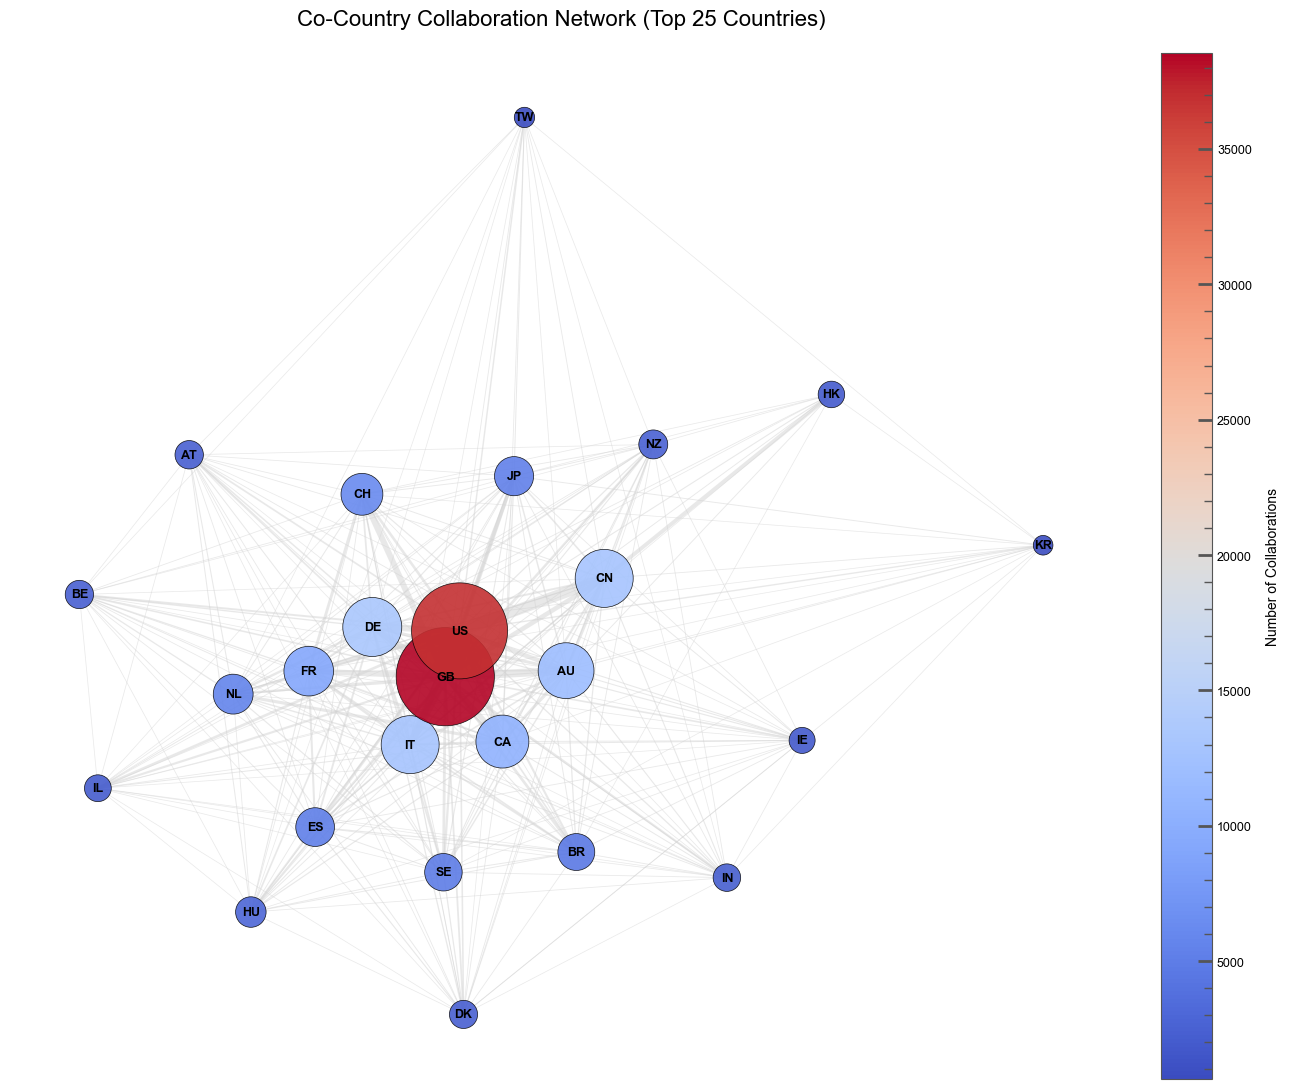

In [74]:


G = nx.Graph()
for (c1, c2), count in pairs_counter.items():
    if c1 != c2 and c1 in top_countries and c2 in top_countries:
        G.add_edge(c1, c2, weight=count)

node_vals = np.array([deg for node, deg in G.degree(weight='weight')])
node_sizes = 200 + (node_vals - node_vals.min()) / (node_vals.max() - node_vals.min() + 1e-9) * (5000 - 200)  

edge_vals = np.array([G[u][v]['weight'] for u, v in G.edges()])
edge_weights = 0.5 + (edge_vals - edge_vals.min()) / (edge_vals.max() - edge_vals.min() + 1e-9) * (20 - 0.5)  # 0.5 à 5 px


cmap = cm.get_cmap("coolwarm")
norm = mcolors.Normalize(vmin=node_vals.min(), vmax=node_vals.max())
colors = cmap(norm(node_vals))

pos = nx.spring_layout(G, k=1.1, weight='weight', seed=42)


fig, ax = plt.subplots(figsize=(13, 11))


nx.draw_networkx_edges(
    G, pos,
    ax=ax,
    width=edge_weights,
    edge_color='lightgray',
    alpha=0.5
)


nx.draw_networkx_nodes(
    G, pos,
    ax=ax,
    node_size=node_sizes,
    node_color=colors,
    alpha=0.9,
    edgecolors='black',
    linewidths=0.5
)


nx.draw_networkx_labels(
    G, pos,
    ax=ax,
    font_size=9,
    font_weight='bold'
)


sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=9)
cbar.set_label("Number of Collaborations", fontsize=10, labelpad=10)


ax.set_title("Co-Country Collaboration Network (Top 25 Countries)", fontsize=16, pad=20)
ax.axis("off")
plt.tight_layout()
plt.show()

